##**Проект: Предсказание активности покупателей интернет-магазинов**

Имеем информацию по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.
В них есть обезличенная история покупок клиентов за определенный период

### **Цель:**
Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

### **Задача**:
Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней


#### **Исходные данные:**
- `marketplace` - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- `apparel` - магазин одежды, по характеристикам похожий на маркетплейс;
- `gifts` – магазин подарков, очень маленький;
   - `client_id` – идентификатор клиента;
   - `quantity` – количество товара в заказе;
   - `price` – цена 1 единицы товара в заказе;
   - `message_id` – идентификатор сообщения из рассылки;
   - `date` – дата покупки;

### **План работы:**
1. Загрузка данных.
   - Импорт необходимых библиотек.
2. Анализ данных (EDA).
3. Предварительная подготовка данных.
   - Создание целевого признака.
   - Cоздние полезных признаков для обучения модели.
   - Формирование общего датасета для дальнейшего исследование и предобработки.
   - Обоснование метрики
4. Обучение модели
5. Тестирование модели
6. Выводы


## **1. Загрузка данных.**
   - Импорт необходимых библиотек.
   - Загрузка и предварительное изучение данных.
   - Предварительная подготовка данных. Объединение данных.
   - Формирование общего датасета для дальнейшего исследование и предобработки.

In [1]:
#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost >> None
    #!pip install orbit-ml >> None
    #!pip install pmdarima >> None
    !"{sys.executable}" -m pip install phik >> None

    print('Environment: Google Colab')

# импорт моделей
#import orbit #общий пакет
#from orbit.models import DLT #один из вариантов модели
#from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
#from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
#from orbit.utils.params_tuning import grid_search_orbit #подбор гиперпараметров
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
# импорт моделей
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix

Environment: Google Colab


In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#from joblib import dump
import pickle
import math
import time
import re
import datetime

# импорт моделей
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

#import pmdarima as pm
#from pmdarima import auto_arima

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, randint
from scipy import stats

# предварительная обработка
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# кроссвалидация
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit, cross_val_score

# метрики
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, make_scorer,
    classification_report)

# настройки
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 12345

In [3]:
try:
    apparel = pd.read_csv('/content/drive/MyDrive/интернет-магазин/apparel-purchases.csvv', sep=',') #, parse_dates=[2], index_col=[0]
    gifts = pd.read_csv('/content/drive/MyDrive/интернет-магазин/gifts-purchases.csv', sep=',') #магазины
    marketplace = pd.read_csv('/content/drive/MyDrive/интернет-магазин/marketplace-purchases.csv', sep=',') #товарная иерархия
    #calendar=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/holidays_covid_calendar.csv', sep=',', parse_dates=[3])
except:
    #если данные храняться на googledisk, подключаем его
    from google.colab import drive
    drive.mount('/content/drive')
    apparel = pd.read_csv('/content/drive/MyDrive/интернет-магазин/apparel-purchases.csv', sep=',', parse_dates=[3]) #, parse_dates=[2], index_col=[0]
    gifts = pd.read_csv('/content/drive/MyDrive/интернет-магазин/gifts-purchases.csv', sep=',', parse_dates=[3]) #магазины
    marketplace = pd.read_csv('/content/drive/MyDrive/интернет-магазин/marketplace-purchases.csv', sep=',', parse_dates=[4,5]) #товарная иерархия
    #calendar=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/holidays_covid_calendar.csv', sep=',', parse_dates=[3])

Mounted at /content/drive


Предварительное изучение данных. Отчистка от явно лишней информации. Формирование общего датасета для дальнейшего исследование и предобработки.

In [4]:
# функция первичного знакомства с данными
def express_info(data, name):
    print(f'Информация о {name}:')
    data.info()
    display(data.head(5))
    print()

In [5]:
express_info(apparel, 'магазине одежды')

Информация о магазине одежды:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [6]:
express_info(gifts, 'магазине подарков')

Информация о магазине подарков:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [7]:
express_info(marketplace, 'макетплейсе')

Информация о макетплейсе:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


In [9]:
#напишем функцию для исследования данных
def research(data, name, figsize1, figsize2, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}') #numeric_data
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')

    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False))#.head(15)

    if not silent:
        print(f'\nПроверка структуры {name}:')
        Y = 0.96
        F = 12/Y
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize1)
        plt.suptitle(f'Гистограмма распределения {name}', y=Y, fontsize=F)
        plt.show()

    if not silent:
        plt.figure(figsize=figsize2)#(40, 20)
        matrix = np.triu(numeric_data.corr())
        heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=13)
        plt.show()
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        display(numeric_data.describe())

    #if not silent:
    display(data.head(5))

Размер данных:      (811, 3)
Количество явных дубликатов: 59
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id    0.0
quantity     0.0
price        0.0
dtype: float64

Проверка структуры данных магазина подарков:


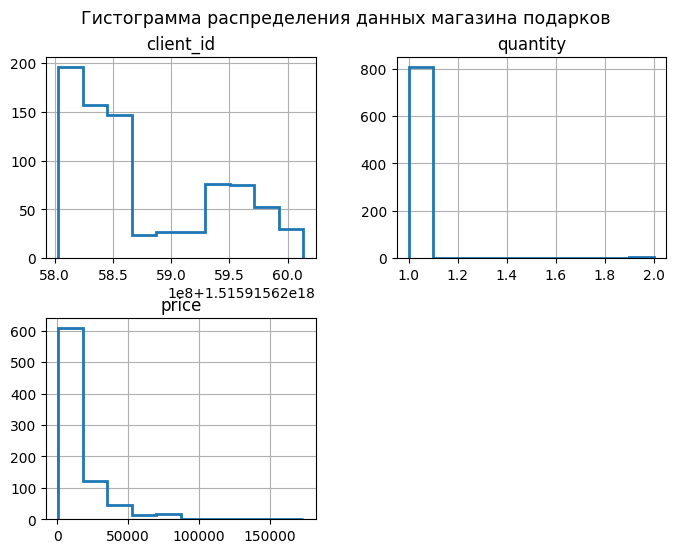

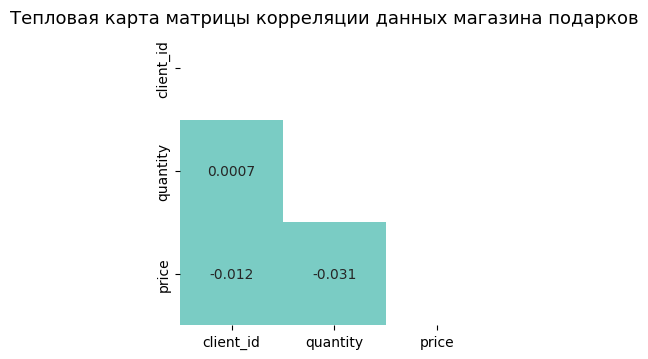

,client_id,quantity,price
count,811.000,811.000,811.000
mean,1515915625875147776.000,1.004,14468.795
std,62554070.490,0.061,17774.342
min,1515915625803180544.000,1.000,656.000
25%,1515915625827804416.000,1.000,3878.000
50%,1515915625857734656.000,1.000,7533.000
75%,1515915625934780416.000,1.000,17938.000
max,1515915626013602560.000,2.000,173586.000


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [10]:
research(gifts, 'данных магазина подарков', figsize1=(8, 6), figsize2=(8, 4), silent=False)

Размер данных:      (48182, 3)
Количество явных дубликатов: 10983
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64

Проверка структуры макетплейса:


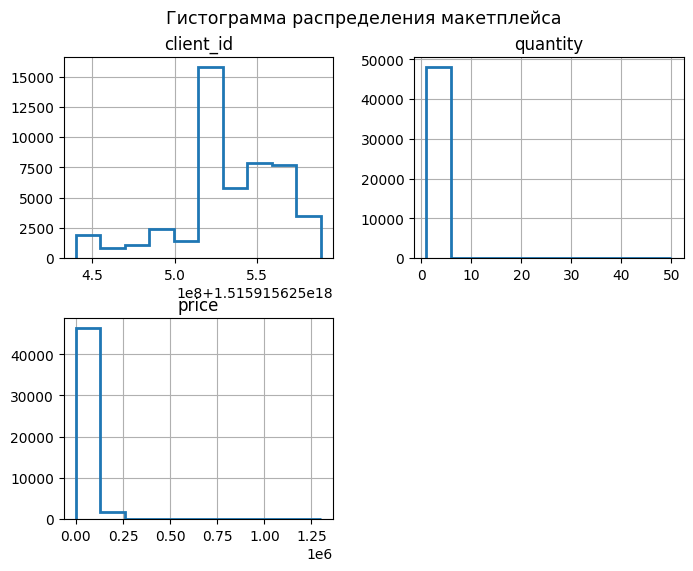

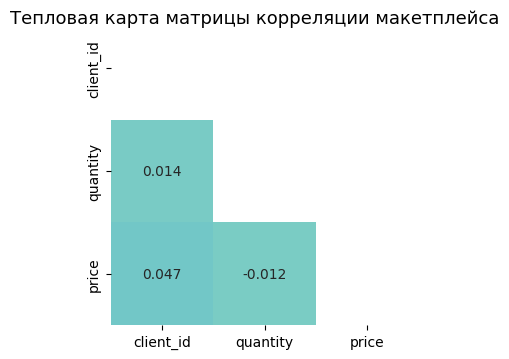

,client_id,quantity,price
count,48182.000,48182.000,48182.000
mean,1515915625532499712.000,1.017,27918.953
std,31733874.279,0.541,44922.742
min,1515915625440099840.000,1.000,0.000
25%,1515915625517591808.000,1.000,1204.250
50%,1515915625531135232.000,1.000,9998.000
75%,1515915625557538816.000,1.000,35998.000
max,1515915625588646144.000,50.000,1299998.000


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.000,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.000,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.000,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.000,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.000,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


In [11]:
research(marketplace, 'макетплейса', figsize1=(8, 6), figsize2=(8, 4), silent=False)

Размер данных:      (133104, 3)
Количество явных дубликатов: 60361
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64

Проверка структуры данных магазина одежды:


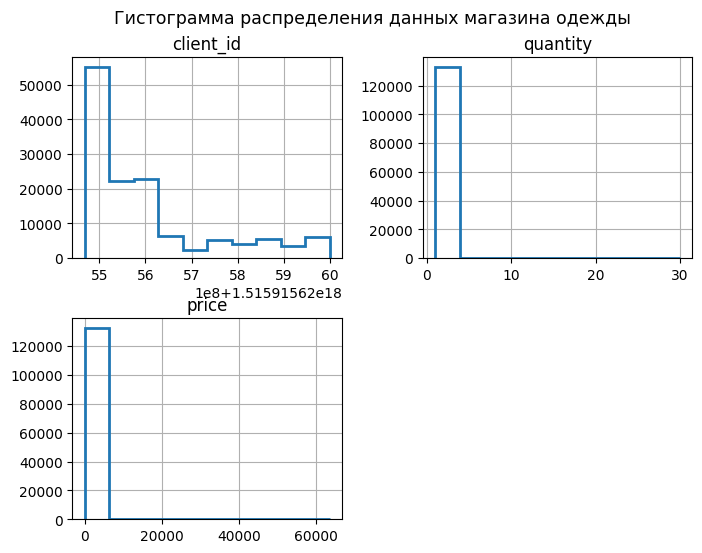

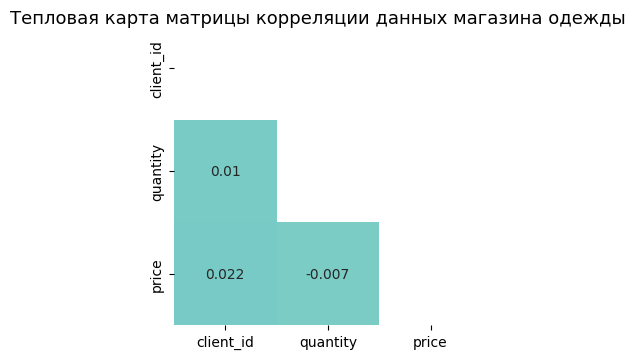

,client_id,quantity,price
count,133104.000,133104.000,133104.000
mean,1515915625597781760.000,1.004,1110.433
std,142207574.423,0.149,1257.081
min,1515915625468060928.000,1.000,1.000
25%,1515915625490427904.000,1.000,280.000
50%,1515915625558532608.000,1.000,799.000
75%,1515915625625638912.000,1.000,1499.000
max,1515915625999034624.000,30.000,63499.000


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [12]:
research(apparel, 'данных магазина одежды', figsize1=(8, 6), figsize2=(8, 4), silent=False)

#### **Вывод:**
- в таблице gifts всего 800 строк - маленьки датасет.
- во всех татасетах более 40% дубликатов - надо более внимательно подойти к анализу.

## **2. Анализ данных (EDA)**
 - Работа с аномалиями, пропусками и дубликатами.
  - Анализ признаков.
  - Анализ временных рядов.

Удалим дубликаты во всех датасетах

In [ ]:
#Удалим явные дубликаты
def dubl(data):
    return data.drop_duplicates()

In [ ]:
#проверим дубликаты с численными значениями
#напишем код
def check_dubl(data):
    numeric_data = data.select_dtypes(include=[np.number])
    all_data_duplicates = data[numeric_data.duplicated(keep=False)]

    #duplicate_numeric_data = data[numeric_data.duplicated()]
    #original_numeric_data = data[~numeric_data.duplicated()]
    #print("Дубликаты:")
    #display(duplicate_numeric_data)
    #print("\nОригинальные записи:")
    #display(original_numeric_data)

    return all_data_duplicates

In [ ]:
apparel = dubl(apparel)
research(apparel, 'данных магазина одежды', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (73854, 3)
Количество явных дубликатов: 1111
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.000,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
6,1515915625468079941,1,999.000,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message
7,1515915625468079941,1,712.000,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message
8,1515915625468079941,1,1499.000,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message


In [ ]:
check_dubl(apparel).head(10)

,client_id,quantity,price,date,message_id,recommended_by
33,1515915625468102493,1,1749.000,2023-09-09,1515915625468102493-3401-623044455acaf,bulk_message
52,1515915625468071652,1,49.000,2023-08-14,1515915625468071652-13626-64d497a66e3a0,bulk_message
53,1515915625468071652,2,49.000,2023-08-14,1515915625468071652-13626-64d497a66e3a0,bulk_message
55,1515915625468071652,1,199.000,2023-08-19,1515915625468071652-13667-64ddcc68a12a1,bulk_message
196,1515915625468122715,1,999.000,2023-08-02,1515915625468122715-13580-64ca0dd5b7d38,bulk_message
227,1515915625468198142,1,999.000,2023-09-16,1515915625468198142-13831-650549ec915c7,bulk_message
255,1515915625468228330,1,1049.000,2023-09-01,1515915625468228330-13749-64f19035a2690,bulk_message
341,1515915625468064438,1,2099.000,2022-10-31,1515915625468064438-7475-635f80c26c660,bulk_message
511,1515915625487897433,1,1749.000,2023-04-08,1515915625487897433-11608-642fdd320f6ee,bulk_message
513,1515915625487897433,1,1749.000,2023-04-29,1515915625487897433-12218-644b83ee8bf7c,bulk_message


In [ ]:
gifts = dubl(gifts)
research(gifts, 'данных магазина магазина подарков', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (755, 3)
Количество явных дубликатов: 3
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.000,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [ ]:
gifts['recommended_by'].unique()

array(['bulk_message'], dtype=object)

In [ ]:
check_dubl(gifts)

,client_id,quantity,price,date,message_id,recommended_by
223,1515915625803892965,1,25990.000,2023-03-21,1515915625864123161-11100-64185f9ab960b,bulk_message
299,1515915625803892965,1,25990.000,2023-05-22,1515915625864123161-12742-646b14f264f93,bulk_message
511,1515915625835005067,1,2230.000,2023-02-06,1515915625835005067-9683-63d4eb258a792,bulk_message
513,1515915625835005067,1,2230.000,2023-02-07,1515915625835005067-9683-63d4eb258a792,bulk_message
755,1515915625855454655,1,5584.000,2022-11-12,1515915625855454655-7772-636cf66c53ee5,bulk_message
757,1515915625855454655,1,5584.000,2022-11-13,1515915625855454655-7813-636e51917d25d,bulk_message


In [ ]:
marketplace = dubl(marketplace)
research(marketplace, 'данных магазина одежды', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (46023, 3)
Количество явных дубликатов: 8824
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.000,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.000,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.000,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.000,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.000,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


In [ ]:
check_dubl(marketplace)

,client_id,quantity,price,message_id,created_at,date
20,1515915625441885478,1,12998.000,1515915625441885478-1744-644a3040879a2,2023-05-04,2023-05-04 06:49:36
23,1515915625442077093,1,34998.000,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 19:52:38
24,1515915625442077093,1,34998.000,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 20:00:04
26,1515915625442077093,1,34998.000,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 20:18:25
36,1515915625443176973,1,37998.000,1515915625443176973-1794-6461ff30d1d36,2023-05-16,2023-05-16 07:38:36
...,...,...,...,...,...,...
48156,1515915625575544090,1,20998.000,1515915625525944269-1738-64479d7e1da12,2023-04-25,2023-04-25 14:14:54
48159,1515915625575644960,1,57998.000,1515915625534596840-1743-6449f5fcb1a32,2023-04-27,2023-04-27 04:27:06
48160,1515915625575644960,1,57998.000,1515915625534596840-1743-6449f5fcb1a32,2023-04-27,2023-04-27 04:28:33
48180,1515915625575809442,1,15998.000,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:48:11


In [ ]:
def clean_data (data, col):
    data = data.drop(col, axis=1)
    return data

In [ ]:
apparel = clean_data (apparel, ['message_id'])
apparel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73854 entries, 0 to 133103
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       73854 non-null  int64         
 1   quantity        73854 non-null  int64         
 2   price           73854 non-null  float64       
 3   date            73854 non-null  datetime64[ns]
 4   recommended_by  73854 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
apparel = dubl(apparel)
research(apparel, 'данных магазина одежды', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (73825, 3)
Количество явных дубликатов: 1082
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,date,recommended_by
0,1515915625468068833,1,3499.000,2023-09-08,bulk_message
3,1515915625468068833,1,2450.000,2023-09-08,bulk_message
6,1515915625468079941,1,999.000,2023-09-01,bulk_message
7,1515915625468079941,1,712.000,2023-09-01,bulk_message
8,1515915625468079941,1,1499.000,2023-09-01,bulk_message


In [ ]:
gifts = clean_data (gifts, ['message_id', 'recommended_by'])
gifts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 810
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   client_id  755 non-null    int64         
 1   quantity   755 non-null    int64         
 2   price      755 non-null    float64       
 3   date       755 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.5 KB


In [ ]:
gifts = dubl(gifts)
research(gifts, 'данных магазина подарков', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (755, 3)
Количество явных дубликатов: 3
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,date
0,1515915625803894158,1,8943.000,2023-10-11
1,1515915625803894158,1,46369.000,2023-10-11
2,1515915625803894158,1,4666.000,2023-10-11
3,1515915625803894158,1,11963.000,2023-10-11
4,1515915625803894158,1,13107.000,2023-10-11


In [ ]:
marketplace = clean_data (marketplace, ['message_id'])
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46023 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   46023 non-null  int64         
 1   quantity    46023 non-null  int64         
 2   price       46023 non-null  float64       
 3   created_at  46023 non-null  datetime64[ns]
 4   date        46023 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 2.1 MB


In [ ]:
marketplace = dubl(marketplace)
research(marketplace, 'данных магазина одежды', figsize1=(8, 6), figsize2=(8, 4), silent=True)

Размер данных:      (46023, 3)
Количество явных дубликатов: 8824
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
client_id   0.000
quantity    0.000
price       0.000
dtype: float64


,client_id,quantity,price,created_at,date
0,1515915625440944408,1,6298.000,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.000,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.000,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.000,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.000,2023-05-25,2023-05-25 07:46:52


### **Выводы:**
- проверила числовые дубликаты - можно сделать вывод, что некоторые из них только с разным `message_id`, почистили
- считаю что во всех датасетах для нашей модели - `message_id` имеет смысл удалить(для нас он не информативны)
- по той же причине имеет смысл удалить `recommended_by` - там только одно уникальное значение, также не несущее смысловой нагрузки.
- также для дальнейшего построения фичей имеет смысл считать сделки в один день за 1 сделку.

### **Проверка на аномалии**

In [13]:
#Напишем функцию для проверки данных на аномалии
def feed_size(data, state, name_state): #, x_lim0, x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(15, 1))
    #plt.xlim([x_lim0, x_lim])
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[state], palette='pastel')
    plt.show()
    print()

    plt.figure(figsize=(15, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #plt.xlim([x_lim0, x_lim])
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины')
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    plt.show()

Статистические данные о распределении значений стоимости товара (price):


count   133104.000
mean      1110.433
std       1257.081
min          1.000
25%        280.000
50%        799.000
75%       1499.000
max      63499.000
Name: price, dtype: float64

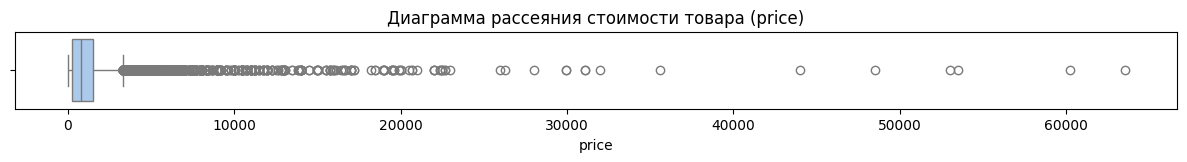

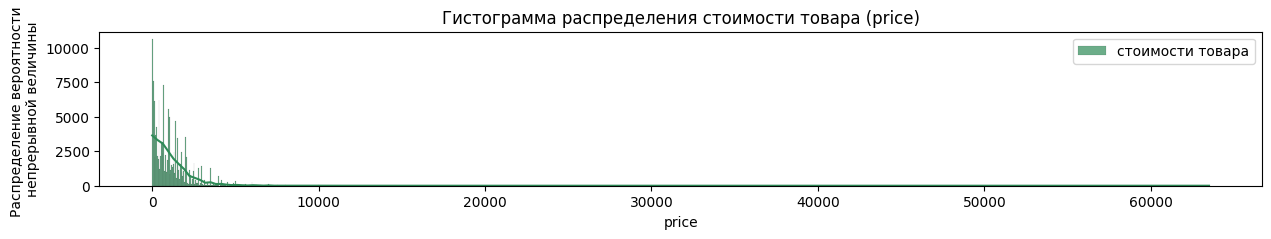

In [14]:
feed_size(apparel, 'price', 'стоимости товара') #, 150

Статистические данные о распределении значений стоимости товара (price):


count      811.000
mean     14468.795
std      17774.342
min        656.000
25%       3878.000
50%       7533.000
75%      17938.000
max     173586.000
Name: price, dtype: float64

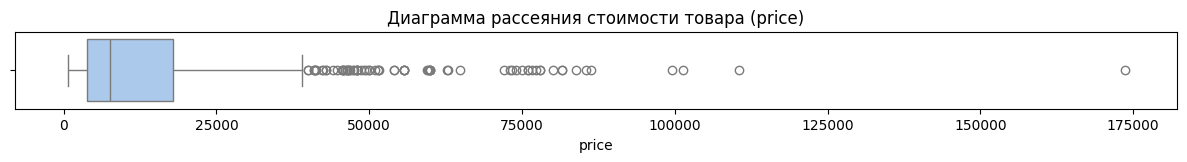

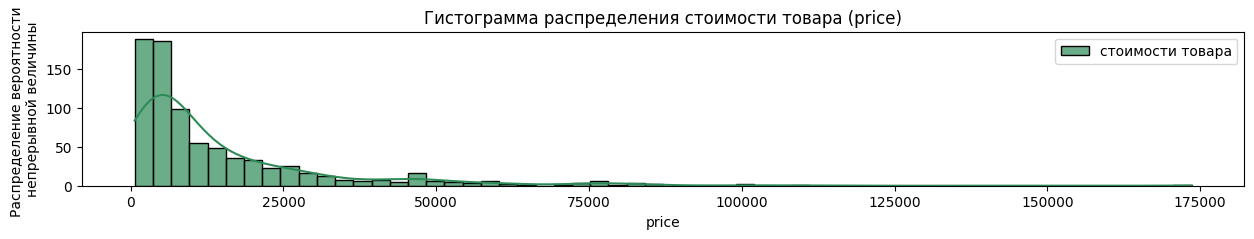

In [15]:
feed_size(gifts, 'price', 'стоимости товара')

In [16]:
gifts[gifts['price']==173586]

,client_id,quantity,price,date,message_id,recommended_by
646,1515915625835000501,1,173586.000,2023-08-29,1515915625835000501-15182-64edee754572e,bulk_message


Статистические данные о распределении значений стоимости товара (price):


count     48182.000
mean      27918.953
std       44922.742
min           0.000
25%        1204.250
50%        9998.000
75%       35998.000
max     1299998.000
Name: price, dtype: float64

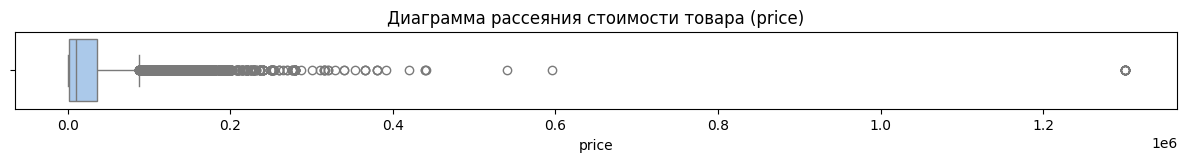

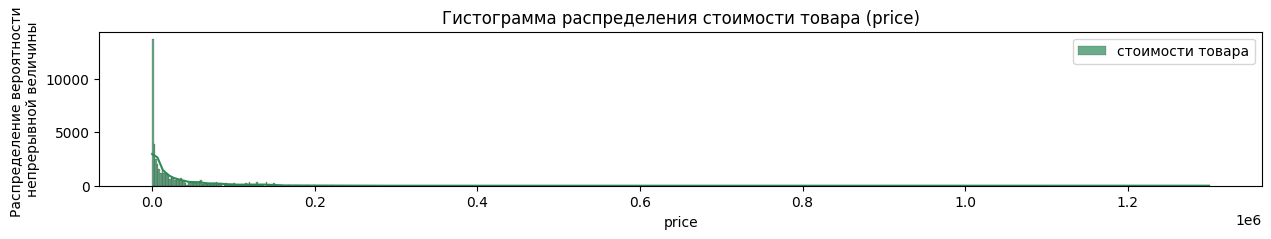

In [17]:
feed_size(marketplace, 'price', 'стоимости товара')

In [18]:
marketplace[marketplace['price']==0]

,client_id,quantity,price,message_id,created_at,date
32019,1515915625520674208,1,0.000,1515915625583796128-2052-64e47cbca8a8a,2023-08-23,2023-08-23 10:09:13
32020,1515915625520674208,1,0.000,1515915625583796128-2052-64e47cbca8a8a,2023-08-23,2023-08-23 10:09:13


In [20]:
# проверим аномальные значения
marketplace[marketplace['price']==1299998]

,client_id,quantity,price,message_id,created_at,date
28725,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:05:30
28726,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:14:08
28727,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:15:50
28728,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:19:33
28729,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:23:29
28730,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 15:42:01
28731,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 16:06:50
28732,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 16:10:16
28733,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 17:03:13
28734,1515915625518981759,1,1299998.000,1515915625518981759-1228-6363456fe269b,2022-11-03,2022-11-03 18:06:15


Большой выброс на макетплейсе - разовая покупка `price` =1299998, посмотрим распределение без него.
> но в принципе, так как у нас задача предсказать не цену, а вероятность покупки, то нам не важно - какая стоимость. Из среза данных виднл, что это не ошибочный запрос, просто дорогой.

In [21]:
marketplace[(marketplace['price']>500000)&(marketplace['price']<1299998)]

,client_id,quantity,price,message_id,created_at,date
18210,1515915625546393273,1,539998.000,1515915625546393273-1472-63d0efdb7593e,2023-01-25,2023-01-25 11:26:58
27402,1515915625441173195,1,595798.000,1515915625441173195-1569-63f85a718cd4c,2023-02-24,2023-02-24 06:35:55


Статистические данные о распределении значений стоимости товара (price):


count    48168.000
mean     27579.622
std      40040.495
min          0.000
25%       1200.000
50%       9998.000
75%      35998.000
max     440996.000
Name: price, dtype: float64

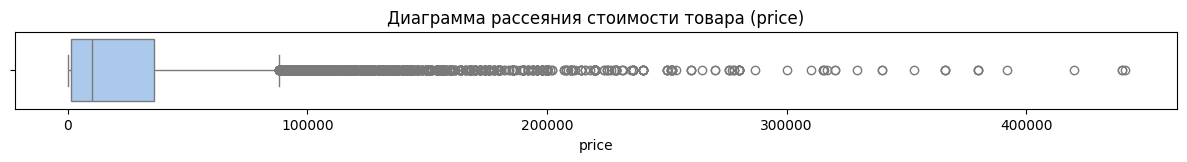

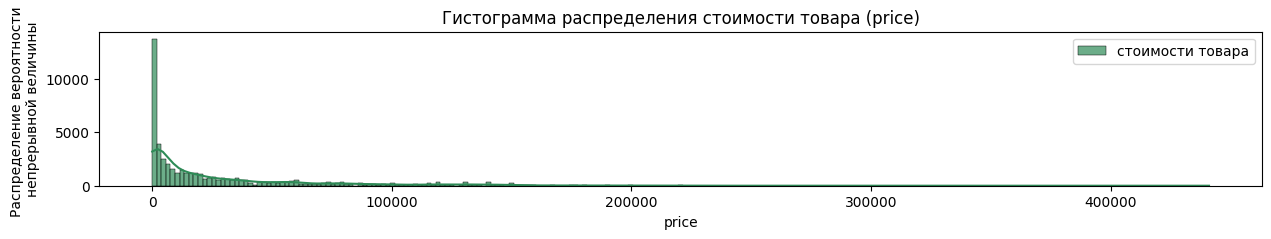

In [22]:
feed_size(marketplace[marketplace['price']<500000], 'price', 'стоимости товара')

Вывод:
- Из анализа данных видно, что во всех данных есть разовые выбросы, пока удалять их не будем, так как он не выглядят аномальными;
- Также следует заметить, что в данных много продаж от отдого покупателя в одно время - при формировании итогового датасета для обучения модели будем считать это за 1 продажу.

### **Временные ряды**

In [23]:
def date_lim (data, name_df, name_col):
    print (f'Начало временного ряда {name_df}: ', data[name_col].min())
    print (f'Конец временного ряда {name_df}: ', data[name_col].max())

In [24]:
date_lim (apparel, 'магазина одежды', 'date')

Начало временного ряда магазина одежды:  2022-10-26 00:00:00
Конец временного ряда магазина одежды:  2023-10-26 00:00:00


In [25]:
date_lim (gifts, 'магазина подарков', 'date')

Начало временного ряда магазина подарков:  2022-10-26 00:00:00
Конец временного ряда магазина подарков:  2023-10-24 00:00:00


In [26]:
date_lim (marketplace, 'макетплейса', 'date')

Начало временного ряда макетплейса:  2022-10-26 08:35:46
Конец временного ряда макетплейса:  2023-10-26 13:34:11


#### Посмотрим общие продажи по прибыли и по количеству совершенных сделок

In [27]:
#Функция исследования продаж
def graph_sales(data, name_y, name_title, name_count):
    plt.figure(figsize=(18, 5))
    sns.lineplot(data=data, x=data.index, y=name_y)
    plt.xlabel('Дата')
    plt.ylabel(f'Продажи, {name_count}')
    plt.title(f'Продажи {name_title}')
    plt.grid(True)
    plt.show()

def date_sales(data, name_sale):
    data_date = data.pivot_table(
    index=['date', 'client_id'], values=[name_sale],
    aggfunc=sum).sort_values(by=name_sale, ascending=False).reset_index()
    data_date.set_index('date', inplace=True)
    display(data_date.sample(3))
    return data_date

##### **Продажи в магазине одежды**

,client_id,quantity
date,,
2023-07-23,1515915625489287346,2
2022-11-11,1515915625583346477,2
2023-05-06,1515915625580498309,2


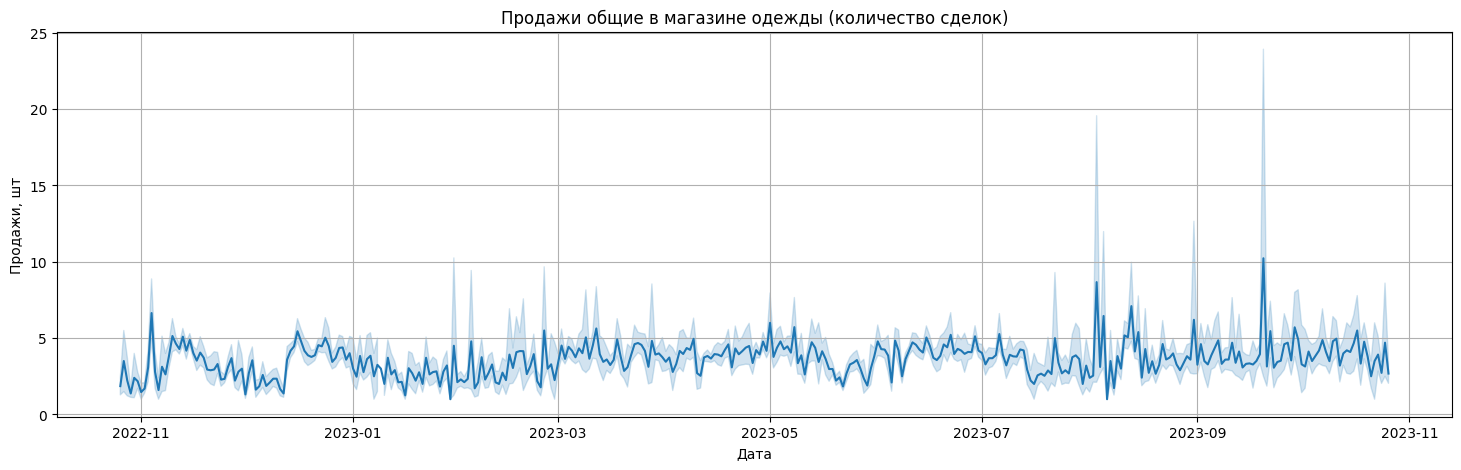

,client_id,price
date,,
2022-11-15,1515915625559606580,1998.000
2023-01-18,1515915625650251753,798.000
2023-07-10,1515915625488822617,4996.000


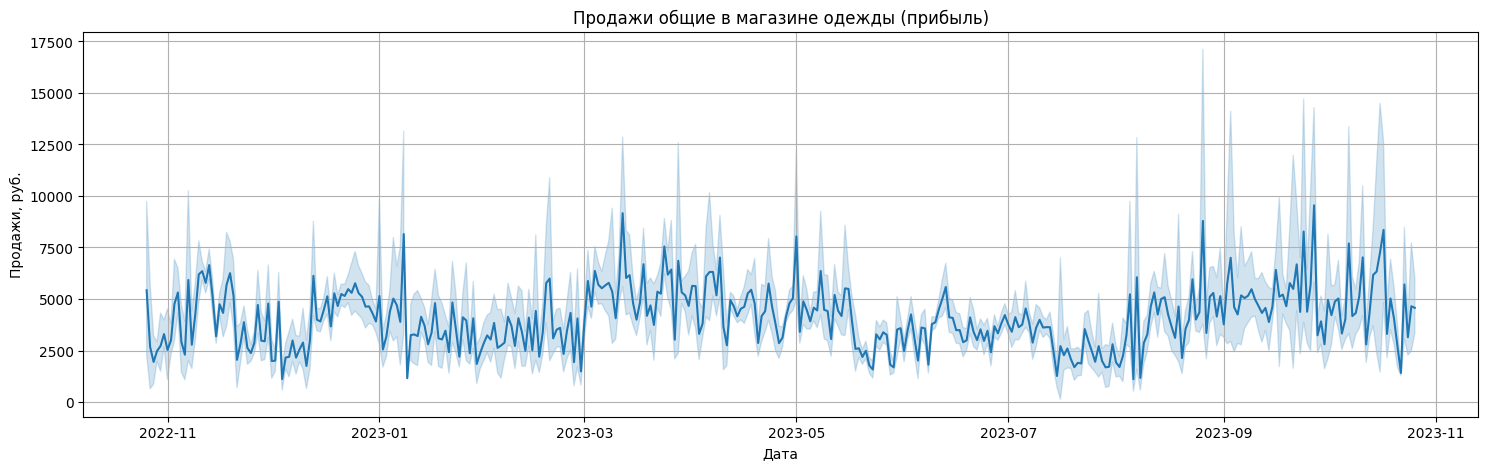

In [28]:
apparel_date_q = date_sales(apparel, 'quantity')
graph_sales(apparel_date_q, 'quantity', 'общие в магазине одежды (количество сделок)', 'шт')
apparel_date_p = date_sales(apparel, 'price')
graph_sales(apparel_date_p, 'price', 'общие в магазине одежды (прибыль)', 'руб.')

- Сезонность в магазине подарков присутствует:
- пики продаж приходятся на середину января, ноябрь и конец августа - делаю предположение, что это связано с сезоном распродаж.

##### **Продажи в магазине подарков**

,client_id,quantity
date,,
2023-02-07,1515915625916866439,2
2023-05-22,1515915625803894158,15
2022-11-19,1515915625861627897,2


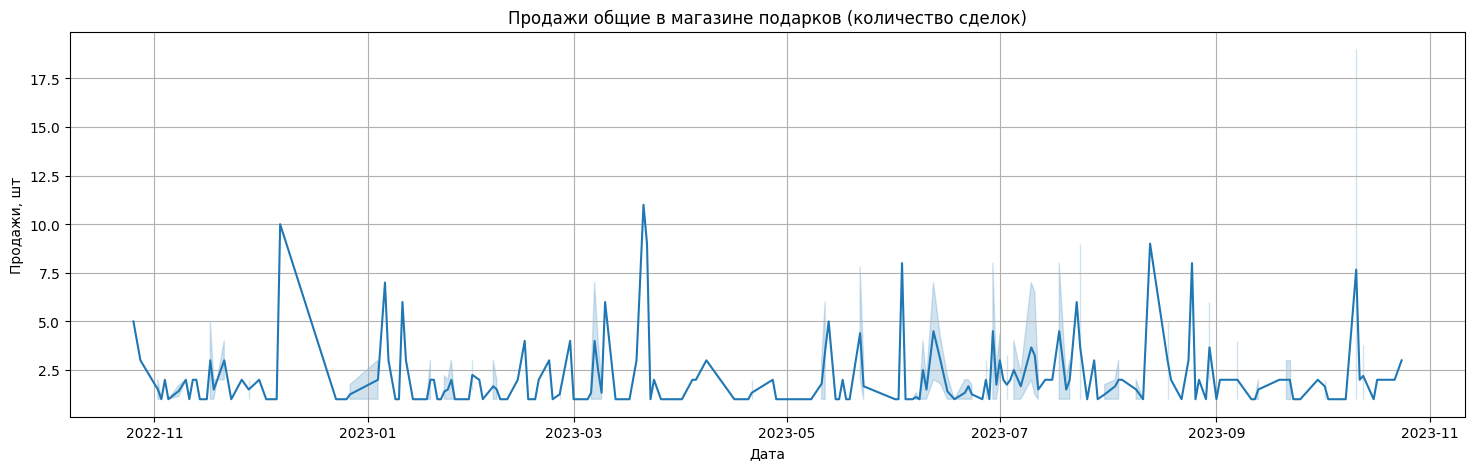

,client_id,price
date,,
2023-06-16,1515915625933450807,54060.000
2023-06-06,1515915625835006190,669.000
2022-12-07,1515915625819603986,88732.000


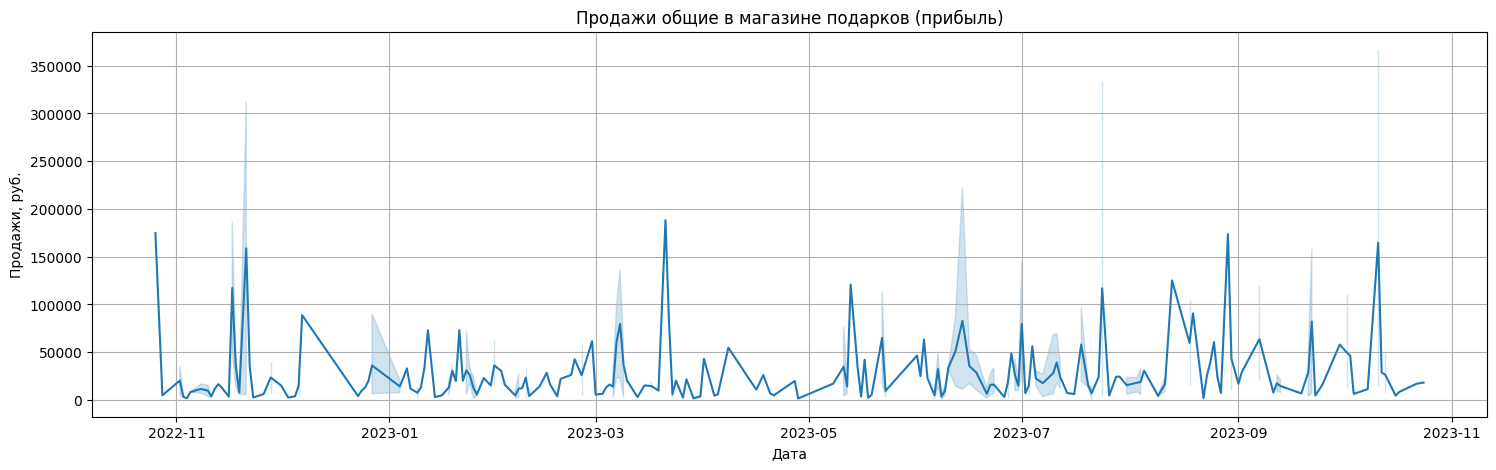

In [ ]:
gifts_date_q = date_sales(gifts, 'quantity')
graph_sales(gifts_date_q, 'quantity', 'общие в магазине подарков (количество сделок)', 'шт')
gifts_date_p = date_sales(gifts, 'price')
graph_sales(gifts_date_p, 'price', 'общие в магазине подарков (прибыль)', 'руб.')

- Сезонноть в магазине подарков также присутствует,
- пик приходится на начало апреля (это интересно, возможно) и стабильные продажи начинаются с начала июня до ноября.
  > предположить, что продукция связана с морем и купальным сезоном (так как в зимние месяцы совсем низкие продажи)

##### **Продажи на макетплейсе**

,client_id,quantity
date,,
2023-09-15 13:22:04,1515915625533574652,1
2022-12-10 03:36:49,1515915625516060969,2
2023-02-28 03:58:32,1515915625540590423,3


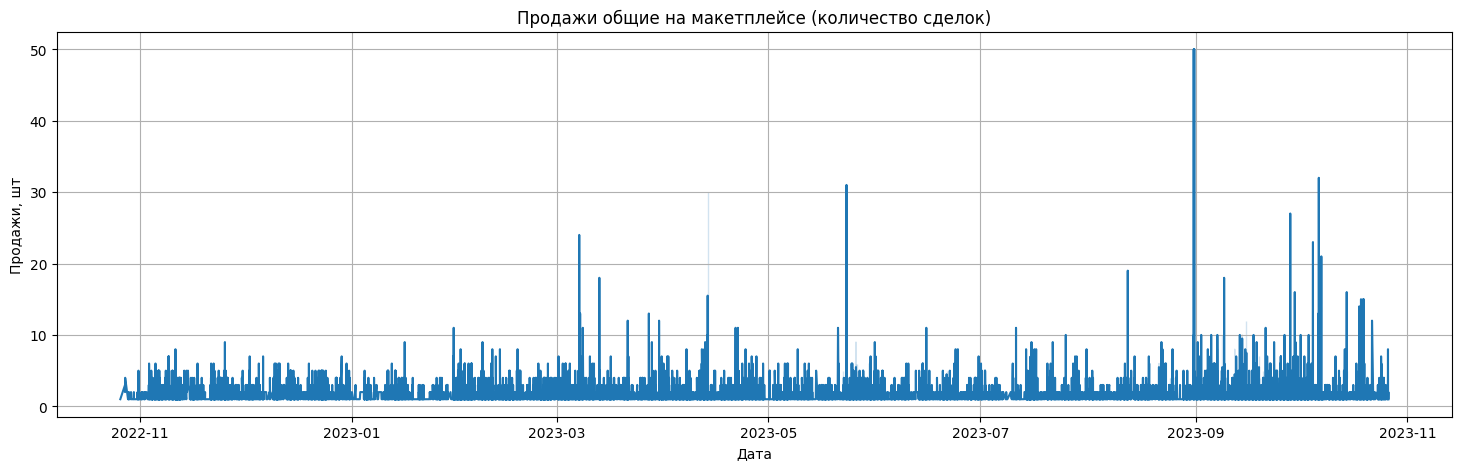

,client_id,price
date,,
2022-11-24 11:21:14,1515915625540142288,251598.000
2023-03-15 16:02:58,1515915625559789800,1598.000
2022-12-22 09:58:55,1515915625463120398,153998.000


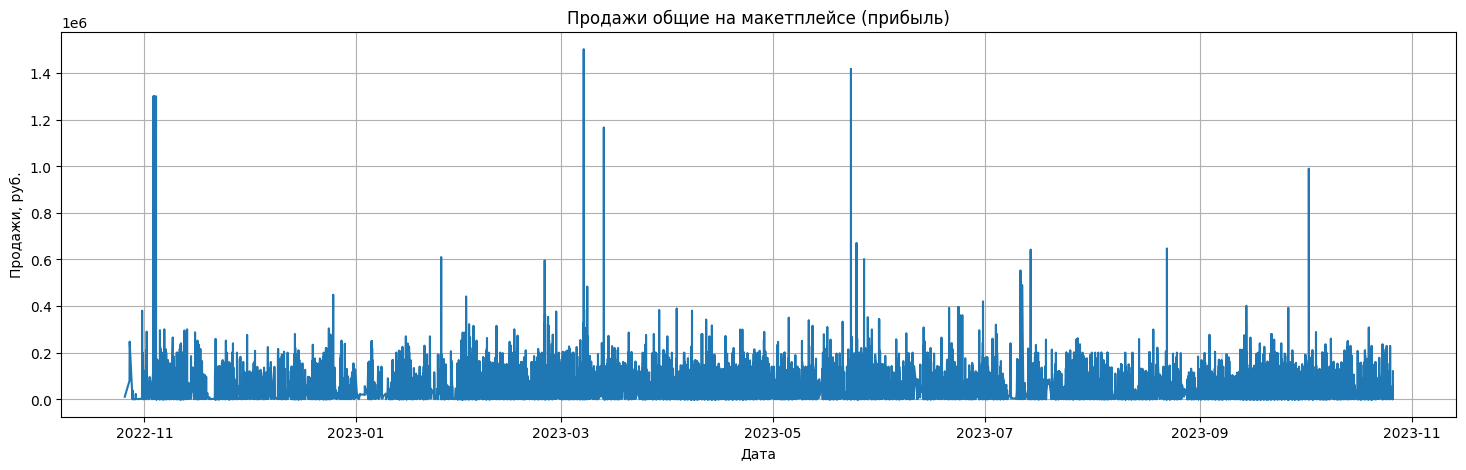

In [ ]:
marketplace_date_q = date_sales(marketplace, 'quantity')
graph_sales(marketplace_date_q, 'quantity', 'общие на макетплейсе (количество сделок)', 'шт')
marketplace_date_p = date_sales(marketplace, 'price')
graph_sales(marketplace_date_p, 'price', 'общие на макетплейсе (прибыль)', 'руб.')

- На маркетплейсе ярко выраженные пики в дни распродаж (ноябрь, февраль-март, август)

In [29]:
def results_stuff(data, col_name, result):
    data_pivot = data.pivot_table(index=['client_id'], values=['price'],aggfunc=sum)\
                  .sort_values(by='price', ascending=True)
    return data_pivot
def graf_results_stuff(data, results):
    ax = data.plot(kind='barh', grid=True, figsize=(14, 7))
    ax.legend(loc='best', bbox_to_anchor=(1, 0.2))
    ax.set_title(results)
    # Выведем ТОП 10 по сотрудникам по реализованным сделкам
#data_pivot_TOP10 = results_stuff(apparel, 'Этап сделки', 'Успешно реализовано')
#display(data_pivot_TOP10.tail(10))
#graf_results_stuff(data_pivot_TOP10,"Успешно реализованные сделки");

### **Выводы:**
- Временные отрезки одинаковые
- Сезонность присутствует во всех магазинах, причем сезонность разная.
- интересное наблюдение, что на маркет плейсе количество сделок не совпадает с общим уровнем дохода - видимо, в сезоны распродаж наиболее дорогие товары покупают.
- в данных много продаж от одного покупателя в одно время - при формировании итогового датасета для обучения модели будем считать это за 1 продажу.

## **3. Предварительная подготовка данных.**

### **Создаем таргет для дальнейшего обучения модели**
Будем рассматривать вариант статистической модели

- Найдем id клиентов, которые совершили покупку в последние 30 дней - сохраняем в список
- Дропаем данные последнего месяца.
- группируем данные только по клиентам, добавляем нужные фичи
- Клиентам которые есть в сохранённом массиве (списке) присваиваешь таргет 1, другим 0.

Найдем id клиентов, которые совершили покупку в последние 30 дней - сохраняем в список

In [31]:
#Сохраняем список id клиентов, которые совершили покупку за последний месяц.
def id_clients(data, date):
    # продажи в магазинах
    data_pivot = data.pivot_table(
                    index=['client_id', 'date'], values=['price', 'quantity'],
                    aggfunc={'quantity': [np.mean, sum],
                             'price': [min, max, np.mean, sum]},
                    fill_value=0).sort_values(by='date', ascending=False)#.head(20)
    data_pivot.columns = [f'{a}_{b}' for a, b in data_pivot.columns]
    data_pivot.reset_index(inplace=True)

    list_id =  data_pivot.apply(lambda x: x['client_id'] \
                              if x['price_sum'] != 0 and x['date'] > pd.Timestamp(date)\
                              else None, axis=1).dropna().tolist()
    return list_id, data_pivot

In [32]:
list_id_apparel, data_apparel = id_clients(apparel, '2023-09-25')
len(list_id_apparel)

845

In [33]:
list_id_gifts, data_gifts = id_clients(gifts, '2023-09-25')
print(len(list_id_gifts))
data_gifts.head()

21


,client_id,date,price_max,price_mean,price_min,price_sum,quantity_mean,quantity_sum
0,1515915625902774628,2023-10-24,7262,6046.000,4886,18138,1.000,3
1,1515915625835001905,2023-10-22,13936,8428.500,2921,16857,1.000,2
2,1515915625870015457,2023-10-17,4691,4226.000,3761,8452,1.000,2
3,1515915625941961811,2023-10-17,5131,4026.000,2921,8052,1.000,2
4,1515915625835000620,2023-10-16,4462,4462.000,4462,4462,1.000,1


In [34]:
list_id_marketplace, data_marketplace = id_clients(marketplace, '2023-09-25')
len(list_id_marketplace)

3509

In [35]:
#def id_clients(data):
#    list_id = []
#    for idx, row in data.iterrows():
#        if row['price_sum'] > 0 and row['date'] >  pd.Timestamp('2023-09-25'):
#            list_id.append(row['client_id'])
#    return list_id

#list_id = [row['client_id'] for idx, row in data_apparel.iterrows() \
#           if row['price_sum'] != 0 and row['date'] > pd.Timestamp('2023-09-25')]

In [36]:
### @title sum_price vs median_price
#data_apparel_gb.plot(kind='scatter', x='sum_price', y='median_price', s=32, alpha=.8)
#plt.gca().spines[['top', 'right',]].set_visible(False)

#### Удаляем информацию о последнем месяце
 > после '2023-09-25'

In [37]:
def drop_30 (data, date):
    data = data[data['date'] <= date]
    return data.sort_values(by = 'date')

In [38]:
apparel_target = drop_30(apparel, '2023-09-25')
date_lim (apparel_target, 'магазина одежды', 'date')

Начало временного ряда магазина одежды:  2022-10-26 00:00:00
Конец временного ряда магазина одежды:  2023-09-25 00:00:00


In [39]:
gifts_target = drop_30(gifts, '2023-09-24')
date_lim (gifts_target, 'магазина подарков', 'date')

Начало временного ряда магазина подарков:  2022-10-26 00:00:00
Конец временного ряда магазина подарков:  2023-09-23 00:00:00


In [40]:
gifts_target #.sort_values(by = 'date')

,client_id,quantity,price,date,message_id,recommended_by
210,1515915625857065470,1,54040.000,2022-10-26,1515915625835003105-7412-63592c6162660,bulk_message
213,1515915625857065470,1,11505.000,2022-10-26,1515915625835003105-7412-63592c6162660,bulk_message
209,1515915625857065470,1,59990.000,2022-10-26,1515915625835003105-7412-63592c6162660,bulk_message
212,1515915625857065470,1,12513.000,2022-10-26,1515915625835003105-7412-63592c6162660,bulk_message
211,1515915625857065470,1,36720.000,2022-10-26,1515915625835003105-7412-63592c6162660,bulk_message
...,...,...,...,...,...,...
184,1515915625861627387,1,29592.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message
183,1515915625861627387,1,86351.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message
182,1515915625861627387,1,41346.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message
177,1515915625826759645,1,6778.000,2023-09-22,1515915625826759645-15708-650d83a19f5bb,bulk_message


In [41]:
marketplace_target = drop_30(marketplace, '2023-09-25')
date_lim (marketplace_target, 'магазина одежды', 'date')

Начало временного ряда магазина одежды:  2022-10-26 08:35:46
Конец временного ряда магазина одежды:  2023-09-24 18:54:42


### **Создание новых фичей.**

#### Группируем данные по клиентам  
> добавляем фичи:
 - оставляем дату 1 и последнюю дату покупки
 - суммируем количесвтво покупок в эту дату
 - период времени между 1 и 2 покупкой
 -  средний чек,
 - минимальный чек
 - максимальный чек
 - средний чек
 - добавляем таргет


In [42]:
# подготовим базовый датасет - создадим новые фичи
def form_df(data, silent):
    data['first_date'] = data.groupby('client_id')['date'].transform('min')#.transform('first')
    data['last_date'] = data.groupby('client_id')['date'].transform('max') #.transform('last')

    data['next_date'] = data.groupby('client_id')['date'].shift(-1)
    data['period_sale'] = (data['next_date'] - data['first_date']).dt.days
    # заполним пропущенные значения в столбце next_purchase_days_diff
    data['period_sale'] = data['period_sale'].fillna(method='ffill') #apparel_target['period_sale'].mode()[0]
    #для динамической модели
    if silent:
        data['target'] = np.where(data['period_sale'] > 30,0,1)
    #data[data['client_id'] == 1515915625591830239] #1515915625558243164
    return data

In [43]:
apparel_target[apparel_target['client_id'] == 1515915625591830239] #1515915625558243164

,client_id,quantity,price,date,message_id,recommended_by
111129,1515915625591830239,1,1333.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111128,1515915625591830239,1,1333.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111127,1515915625591830239,1,1332.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111126,1515915625591830239,1,1332.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111125,1515915625591830239,1,1999.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111124,1515915625591830239,1,1999.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111121,1515915625591830239,1,1333.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111123,1515915625591830239,1,1999.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message
111122,1515915625591830239,1,1333.000,2023-04-15,1515915625591830239-11897-64396d47a0aa0,bulk_message


In [44]:
apparel_target = form_df(apparel_target, silent=False)
apparel_target.tail()

,client_id,quantity,price,date,message_id,recommended_by,first_date,last_date,next_date,period_sale
12205,1515915625489479586,1,2999.000,2023-09-25,1515915625489479586-13855-650d4d405642f,bulk_message,2023-09-25,2023-09-25,NaT,0.000
50895,1515915625574758181,1,1499.000,2023-09-25,1515915625810556341-13855-650d4d545a227,bulk_message,2023-09-25,2023-09-25,2023-09-25,0.000
50896,1515915625574758181,1,1499.000,2023-09-25,1515915625810556341-13855-650d4d545a227,bulk_message,2023-09-25,2023-09-25,NaT,0.000
634,1515915625478523868,1,613.000,2023-09-25,1515915625478523868-7252-6350f2112ab38,bulk_message,2023-09-24,2023-09-25,NaT,0.000
109925,1515915625875714074,1,420.000,2023-09-25,1515915625875714074-13864-651141a538eae,bulk_message,2023-06-11,2023-09-25,NaT,0.000


In [45]:
gifts_target = form_df(gifts_target, silent=False)
gifts_target.tail()

,client_id,quantity,price,date,message_id,recommended_by,first_date,last_date,next_date,period_sale
184,1515915625861627387,1,29592.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message,2023-09-22,2023-09-22,2023-09-22,0.000
183,1515915625861627387,1,86351.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message,2023-09-22,2023-09-22,2023-09-22,0.000
182,1515915625861627387,1,41346.000,2023-09-22,1515915625861627387-15680-650c4a88dceb0,bulk_message,2023-09-22,2023-09-22,NaT,0.000
177,1515915625826759645,1,6778.000,2023-09-22,1515915625826759645-15708-650d83a19f5bb,bulk_message,2023-09-22,2023-09-22,NaT,0.000
198,1515915625986174436,1,4495.000,2023-09-23,1515915625986174436-15708-650d83a19ce69,bulk_message,2023-09-23,2023-09-23,NaT,0.000


In [46]:
marketplace_target = form_df(marketplace_target, silent=False)
marketplace_target.tail()

,client_id,quantity,price,message_id,created_at,date,first_date,last_date,next_date,period_sale
3105,1515915625516080066,1,15998.000,1515915625516080066-2117-650e70feebfc6,2023-09-24,2023-09-24 17:40:30,2022-11-12 10:49:41,2023-09-24 17:40:30,NaT,316.000
14332,1515915625527569704,1,2373.000,1515915625527569704-2119-650fd12dd0124,2023-09-24,2023-09-24 18:06:34,2022-11-09 08:22:41,2023-09-24 18:06:34,NaT,316.000
20317,1515915625558483577,1,6298.000,1515915625558483577-2117-650e71084df1d,2023-09-24,2023-09-24 18:17:04,2023-09-24 18:17:04,2023-09-24 18:17:04,NaT,316.000
8404,1515915625518974265,1,2.000,1515915625518974265-2119-650fd12c53fda,2023-09-24,2023-09-24 18:54:42,2023-09-24 18:54:42,2023-09-24 18:54:42,2023-09-24 18:54:42,0.000
8403,1515915625518974265,1,4.000,1515915625518974265-2119-650fd12c53fda,2023-09-24,2023-09-24 18:54:42,2023-09-24 18:54:42,2023-09-24 18:54:42,NaT,0.000


In [47]:
# напишем функцию группировки данных + добавление таргета
def form_final_df(data):
    data = data.pivot_table(index=['client_id'], values=['price', 'quantity'],\
                    aggfunc = {'quantity': [np.mean, sum],
                             'price': [min, max, sum],  #, np.mean
                             'date': lambda x: x.iloc[0]},
    fill_value=0).sort_values(by='date', ascending=False)#.head(20)
    data.columns = [f'{a}_{b}' for a, b in data.columns]
    data.reset_index(inplace=True)
    return data

In [48]:
# напишем функцию группировки данных + добавление таргета (статистическая модель)
def form_final_df(data, list_id):
    data_sorted = data.sort_values('date')
    # Группируем по 'client_id' и выбираем первую дату и количество 'quantity'
    final_data = data_sorted.groupby('client_id').agg({
                                    'date': ['first'], #, 'last',lambda x: x.iloc[0]
                                    'period_sale': [np.mean],
                                    'quantity': [sum],
                                    'price': [min, max, sum] #, np.mean, 'avg_price'
                                    }, observed=True)

    # Переименовываем столбцы для удобства
    final_data.columns = ['first_date', 'avg_period_sale', 'avg_quantity', 'min_price', 'max_price', 'total_price'] #, 'last_date'
    final_data.reset_index(inplace=True)

    # Создаем целевой признак
    final_data['target'] = np.where(final_data['client_id'].isin(list_id), 1, 0)

    # создаем колонку с датой 2 сделки
    #final_data['next_date'] = final_data.groupby('client_id')['last_date'].shift(+1)
    #final_data['next_date'] = final_data.groupby('client_id')['first_date'].shift(-1)
    #final_data['next2_date'] = final_data['next_date'].shift(-1)

    return final_data.sort_values(by='first_date', ascending=True)

In [49]:
apparel_final = form_final_df(apparel_target, list_id_apparel)
apparel_final.sample(5)

,client_id,first_date,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
26921,1515915625956727732,2023-04-22,0.000,2,630.000,999.000,1629.000,0
25362,1515915625867018951,2022-12-29,7.500,6,1400.000,1799.000,9896.000,0
19312,1515915625591084634,2022-11-11,0.000,4,699.000,2799.000,6996.000,0
17304,1515915625581320506,2022-12-19,2.300,10,5.000,1699.000,9447.000,0
7241,1515915625490665631,2023-06-06,0.000,2,559.000,559.000,1118.000,0


In [52]:
gifts_final = form_final_df(gifts_target, list_id_gifts)
gifts_final.head()

,client_id,first_date,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
129,1515915625857065470,2022-10-26,0.000,5,11505.000,59990.000,174768.000,0
112,1515915625842031428,2022-10-28,0.000,3,842.000,2287.000,4821.000,0
96,1515915625835005143,2022-11-02,0.000,4,17100.000,18000.000,70200.000,0
34,1515915625805906601,2022-11-02,0.000,1,5236.000,5236.000,5236.000,0
95,1515915625835005077,2022-11-03,0.000,8,3627.000,3627.000,29016.000,0


In [53]:
marketplace_final = form_final_df(marketplace_target, list_id_marketplace)
marketplace_final.head()

,client_id,first_date,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
12582,1515915625562386426,2022-10-26 08:35:46,NaN,1,10598.000,10598.000,10598.000,0
6225,1515915625519806198,2022-10-27 17:12:22,0.000,9,2.000,84998.000,461985.000,0
12204,1515915625560501241,2022-10-28 13:46:57,0.000,1,973.000,973.000,973.000,0
12284,1515915625560931337,2022-10-28 15:04:11,0.000,1,29998.000,29998.000,29998.000,0
9440,1515915625542470986,2022-10-28 15:23:02,0.000,2,2.000,2.000,4.000,0


In [70]:
# переведем 'client_id' в индексы, чтобы избежать утечки
def final(data):
    #data['client_id'] = pd.factorize(data['client_id'])[0]
    data = data.set_index('client_id', inplace=True)  #data.reset_index()
final(apparel_final)
final(gifts_final)
final(marketplace_final)

In [60]:
# продажи в магазинах
data_apparel_small = apparel.pivot_table(
    index=['client_id', 'date'], values=['price', 'quantity'],
    aggfunc=sum).sort_values(by='date', ascending=False)#.head(20)
data_apparel_small.head(10)

,,price,quantity
client_id,date,,
1515915625999034637,2023-10-26,11470.000,6
1515915625559408913,2023-10-26,3199.000,1
1515915625966621493,2023-10-26,5596.000,6
1515915625487379366,2023-10-26,599.000,1
1515915625487380431,2023-10-26,5998.000,2
1515915625570233176,2023-10-26,840.000,2
1515915625491813265,2023-10-26,4620.000,2
1515915625565164459,2023-10-26,7999.000,1
1515915625561404514,2023-10-26,4998.000,2


In [61]:
def results_stuff(data, col_name, result):
    #data.query("`Этап сделки` == 'Успешно реализовано'") data[data[col_name] == result], 'date'
    data_pivot = data.pivot_table(index=['client_id'], values=['total_price'],aggfunc=sum)\
                  .sort_values(by='total_price', ascending=True)
    return data_pivot
def graf_results_stuff(data, results):
    ax = data.plot(kind='barh', grid=True, figsize=(14, 7))
    ax.legend(loc='best', bbox_to_anchor=(1, 0.2))
    ax.set_title(results)

#### **Проверим призднаки на корреляцию**

In [62]:
#напишем функцию для исследования данных
def corr_matrix (data, name, figsize, silent):
  # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}') #numeric_data
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')

    if not silent:

    #тепловая карта корреляций
        plt.figure(figsize=figsize)#(40, 20)
        matrix = np.triu(numeric_data.corr())
        heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=13)
        plt.show()
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        display(numeric_data.describe())


Размер данных:      (28227, 6)
Количество явных дубликатов: 11540
Наличие пропусков:           0


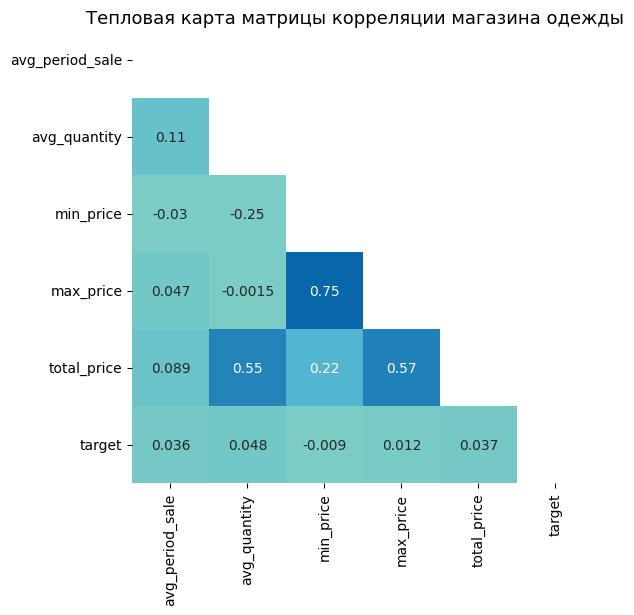

,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
count,28227.000,28227.000,28227.000,28227.000,28227.000,28227.000
mean,9.799,4.612,1155.637,1708.022,5079.909,0.013
std,31.862,5.965,1383.913,1574.918,6796.410,0.112
min,0.000,1.000,1.000,1.000,1.000,0.000
25%,0.000,2.000,279.000,799.000,1598.000,0.000
50%,0.000,3.000,887.000,1399.000,3078.000,0.000
75%,0.000,6.000,1540.000,2100.000,5998.000,0.000
max,312.000,240.000,53499.000,63499.000,206996.000,1.000


CPU times: user 284 ms, sys: 96.3 ms, total: 380 ms
Wall time: 291 ms


In [63]:
%%time
corr_matrix (apparel_final, 'магазина одежды', figsize=(6,6), silent=False)

Размер данных:      (308, 6)
Количество явных дубликатов: 7
Наличие пропусков:           0


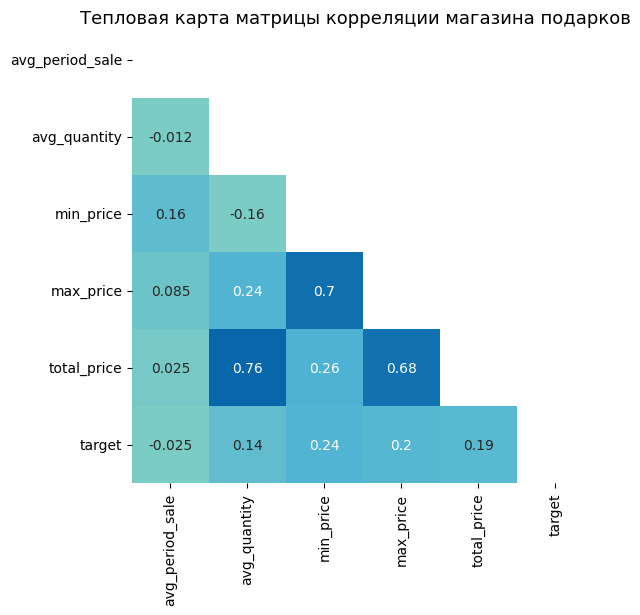

,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
count,308.000,308.000,308.000,308.000,308.000,308.000
mean,14.722,2.448,11451.912,18949.084,34773.143,0.032
std,43.051,3.255,16240.369,21644.745,64231.029,0.178
min,0.000,1.000,656.000,669.000,669.000,0.000
25%,0.000,1.000,2596.750,4494.000,5961.750,0.000
50%,0.000,1.000,5201.500,11498.500,16092.000,0.000
75%,1.000,3.000,14005.000,24303.250,34179.500,0.000
max,229.000,39.000,173586.000,173586.000,594503.000,1.000


CPU times: user 266 ms, sys: 99.2 ms, total: 365 ms
Wall time: 284 ms


In [64]:
%%time
corr_matrix (gifts_final, 'магазина подарков', figsize=(6,6), silent=False)

Размер данных:      (16005, 6)
Количество явных дубликатов: 4667
Наличие пропусков:           1


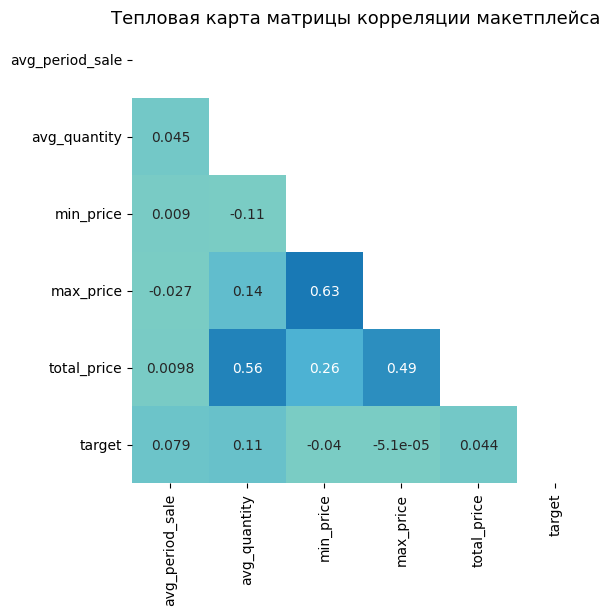

,avg_period_sale,avg_quantity,min_price,max_price,total_price,target
count,16004.000,16005.000,16005.000,16005.000,16005.000,16005.000
mean,27.061,2.725,22192.305,42598.551,76317.572,0.055
std,56.777,6.222,39192.801,48918.565,239048.073,0.228
min,0.000,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,198.000,5998.000,7198.000,0.000
50%,0.000,2.000,4899.000,23998.000,31998.000,0.000
75%,26.000,3.000,24289.000,62999.000,91994.000,0.000
max,323.000,315.000,1299998.000,1299998.000,17300385.000,1.000


CPU times: user 283 ms, sys: 95.1 ms, total: 378 ms
Wall time: 288 ms


In [65]:
%%time
corr_matrix (marketplace_final, 'макетплейса', figsize=(6,6), silent=False)

In [66]:
# удалим пропуски
marketplace_final.dropna(inplace=True)
apparel_final.dropna(inplace=True)

#### **Определим дисбалланс классов целевого признака**

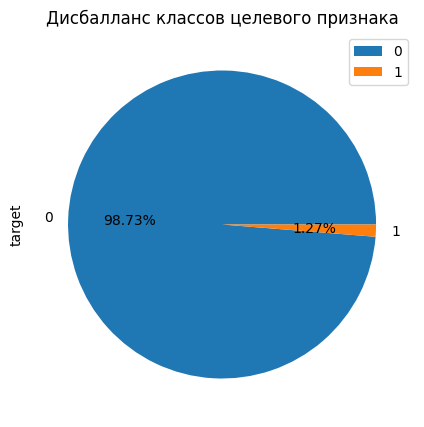

In [55]:
#визуализирую данные
def plot_pie(data, title):
  graph = data.value_counts()\
  .plot.pie(legend=True,labeldistance=1.1, autopct='%1.2f%%', figsize=(5,5))
  plt.title(title)
  plt.show()
plot_pie(apparel_final['target'], 'Дисбалланс классов целевого признака')
#data['exited']: 1 - купили, прекратили, 0 - не купили

In [56]:
# напишем код проверки целевого признака на дисбалланс
def imbalance(data, name_shop):
    imbalance = data['target'].value_counts()
    #display(data)
    plt.bar(imbalance.index, imbalance.values)
    plt.xticks(imbalance.index, labels=['Non-target', 'Target'])
    plt.xlabel('Класс')
    plt.ylabel('Счетчик')
    plt.title(f'Дисбалланс классов целевого признака {name_shop}')
    plt.show()
    plt.figure(figsize=(4,3))
    plt.pie(imbalance.values, labels=['Non-target', 'Target'], autopct='%1.1f%%', startangle= 45)
    plt.axis('equal')  # равные пропорции
    plt.title(f'Дисбалланс классов целевого признака \n {name_shop}')
    plt.show()

#imbalance(apparel_final, 'магазина одежды')

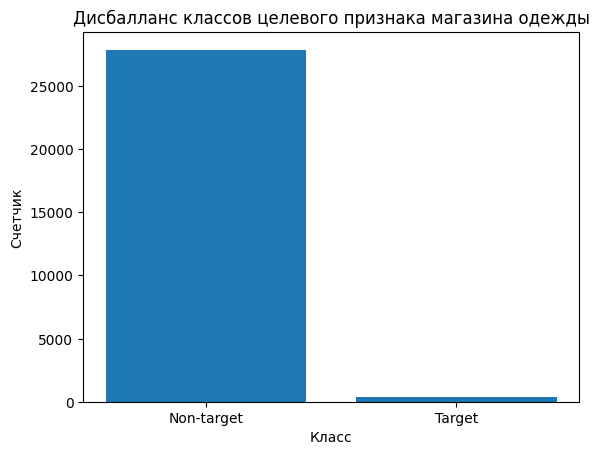

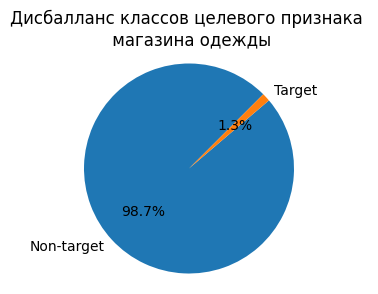

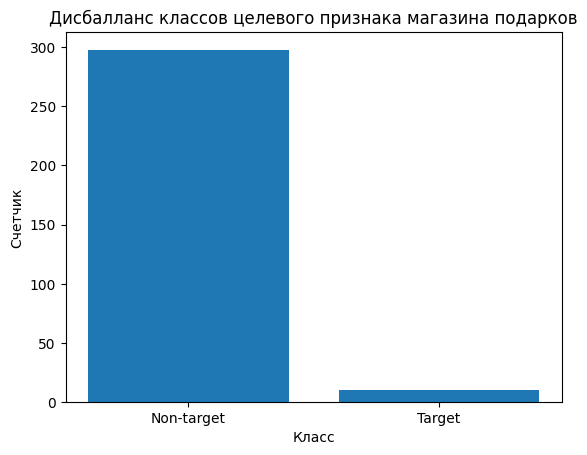

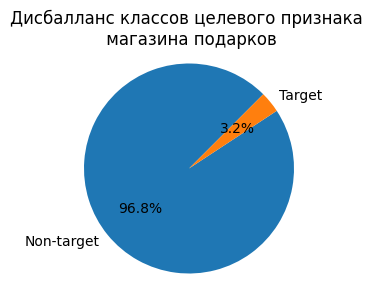

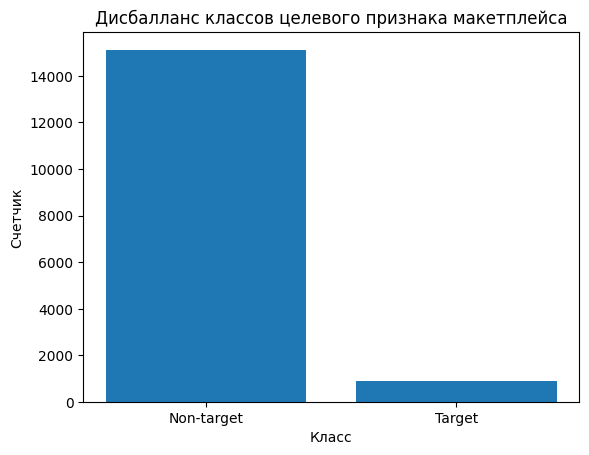

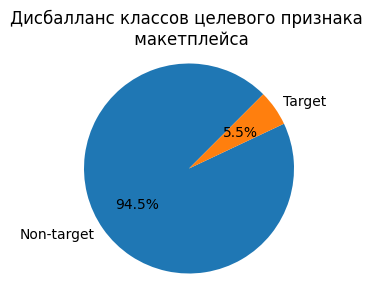

In [68]:
imbalance(apparel_final, 'магазина одежды')
print()
imbalance(gifts_final, 'магазина подарков')
print()
imbalance(marketplace_final, 'макетплейса')
print()

#### **Обоснование метрики**

- В качестве метрики выбираем **`Точность (Pressision)`** и **`Полноту (Recall)`** и **F1-меру**.
> **Полнота** и **точность** оценивают качество прогноза положительного класса с разных позиций. **`Recall`** описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. **`Precision`** выявляет, не переусердствует ли модель, присваивая положительные метки.

- **F1-мера** (F1-score) - среднее гармоническое полноты и точности.
  > **F1-мерой** будем оценивать предварительное качество модели при кросс-валидации
-  При тестовой проыерке - будем также оценивать качество модели **roc-auc**

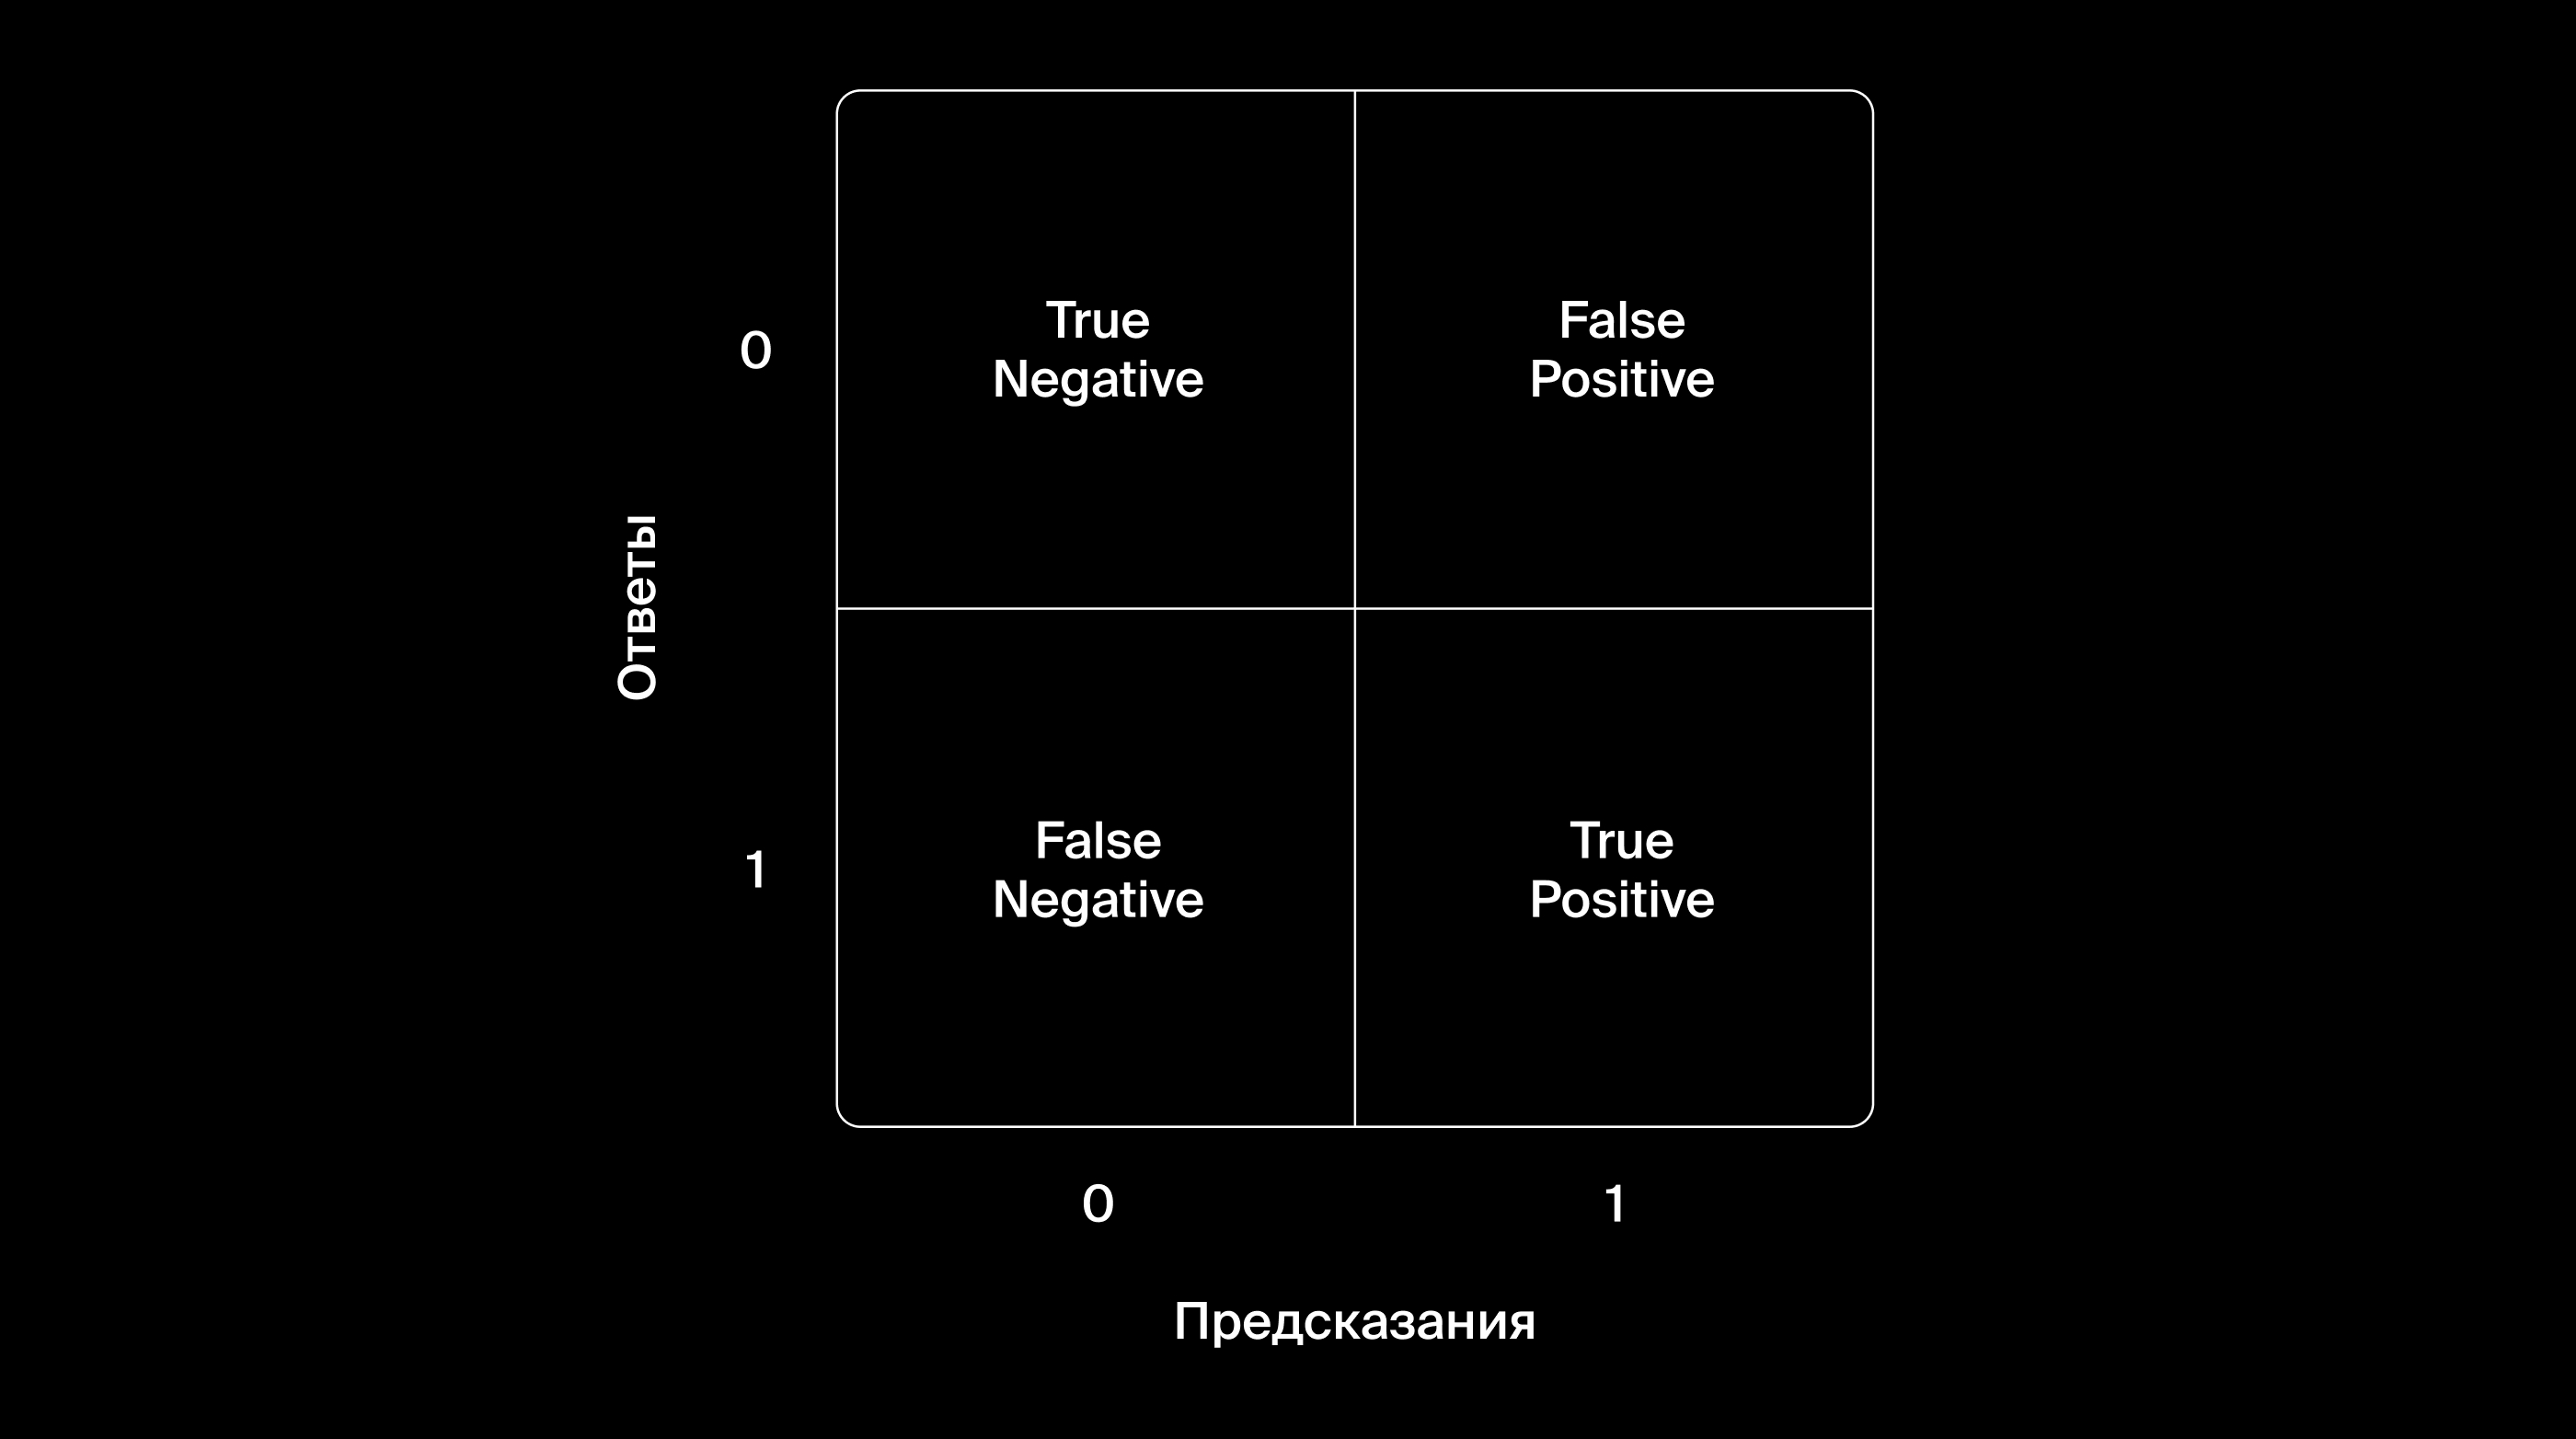

#### **Вывод:**
 - выбрала в качестве подхода - стационарную модель.
 - создала следующие фичи:
   - 1 и последнюю дату покупки
   - количество покупок
   - период времени между 1 и 2 покупкой
   - средний чек - удалила для модели.
   - минимальный чек
   - максимальный чек
   - средний чек
 - Обрезала датасет на 1 месяц, на основе этого последнего месяца создали добавили таргет.
 - При формировании целевого признака обнаружила большой дисбаланс калассов - буду применять увеличение и уменьшение целевого признака, также сделаем баллансировку данных.
 - проверила датасет на корреляцию: Видим, что во всех датасетах наблюдается сильная корреляция между min_price,	max_price и	avg_price	- проверила модель. **avg_price** Решила удалить.
 - проверила на пропуски и дубликаты получившийся датасет - удалила пропуски.

## **4. Обучение моделей:**
- во всех датасетах наблюдается большой дисбалланс целевого признака.
   Проверим работу моделей на обработанных данных:
- Придадим объектам редкого класса больший вес - **`class_weight='balanced'`**.
- поработаем с дисбаллансом - upsampled, downsampled.
- также попробуем поработать с модалями на стандартизированных данных.

In [71]:
# функция разделения данных на обучающую и тестовую выборки
def data_model(data, target_name):
    target = data[target_name]
    features = data.drop(target_name, axis=1)
    features_train, features_test, target_train, target_test = train_test_split(
          features, target, test_size=0.25, random_state=12345)

    print ('Размер обучающих выборок:', features_train.shape, target_train.shape)
    print ('Размер тестовых выборок:', features_test.shape, target_test.shape)
    return features_train, features_test, target_train, target_test

In [72]:
# Функция увеличения выборки положительного класса
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    print ('Размер обучающей выборки с увеличенным положительным классом:', features_upsampled.shape, target_upsampled.shape)
    return features_upsampled, target_upsampled

In [73]:
# Функция уменьшения выборки 0 класса
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    print ('Размер обучающей выборки с уменьшенным  0 классом:', features_downsampled.shape, target_downsampled.shape)
    return features_downsampled, target_downsampled

In [74]:
#Масштабирование признаков - стандартизация данных, при необходимости
def st_scaler(features, features_train):
    # создадим и обучим объект
    scaler = StandardScaler()
    scaler.fit(features_train)
    # стандартизируем данные и реализуем обновленный датафрейм
    features_scale = scaler.transform(features)
    features_scale = pd.DataFrame(features_scale, columns = features.columns)
    return features_scale

Разделим выборки на обучающую и тестовую

In [75]:
# магазин одежды
print ('Магазин одежды:')
features_train_ap, features_test_ap, \
        target_train_ap, target_test_ap = data_model(apparel_final, 'target')

features_upsampled_ap, target_upsampled_ap = upsample(features_train_ap, target_train_ap, 10)
features_downs_ap, target_downs_ap = downsample(features_train_ap, target_train_ap, 0.1)

features_train_scale_ap = st_scaler(features_train_ap.drop(['first_date'], axis=1), features_train_ap.drop(['first_date'], axis=1))
features_test_scale_ap = st_scaler(features_test_ap.drop(['first_date'], axis=1), features_train_ap.drop(['first_date'], axis=1))
print(f'Размер обучающей выборки стандартизированных данных: {features_train_scale_ap.shape}')
print(f'Размер тестовой выборки стандартизированных данных: {features_test_scale_ap.shape}')

Магазин одежды:
Размер обучающих выборок: (21170, 6) (21170,)
Размер тестовых выборок: (7057, 6) (7057,)
Размер обучающей выборки с увеличенным положительным классом: (23456, 6) (23456,)
Размер обучающей выборки с уменьшенным  0 классом: (2346, 6) (2346,)
Размер обучающей выборки стандартизированных данных: (21170, 5)
Размер тестовой выборки стандартизированных данных: (7057, 5)


In [76]:
# магазин подарков
print ('Магазин подарков:')
features_train_g, features_test_g, \
        target_train_g, target_test_g = data_model(gifts_final, 'target')

features_upsampled_g, target_upsampled_g = upsample(features_train_g, target_train_g, 10)
features_downs_g, target_downs_g = downsample(features_train_g, target_train_g, 0.1)

features_train_scale_g = st_scaler(features_train_g.drop(['first_date'], axis=1), features_train_g.drop(['first_date'], axis=1))
features_test_scale_g = st_scaler(features_test_g.drop(['first_date'], axis=1), features_train_g.drop(['first_date'], axis=1))
print(f'Размер обучающей выборки стандартизированных данных: {features_train_scale_ap.shape}')
print(f'Размер тестовой выборки стандартизированных данных: {features_test_scale_ap.shape}')

Магазин подарков:
Размер обучающих выборок: (231, 6) (231,)
Размер тестовых выборок: (77, 6) (77,)
Размер обучающей выборки с увеличенным положительным классом: (294, 6) (294,)
Размер обучающей выборки с уменьшенным  0 классом: (29, 6) (29,)
Размер обучающей выборки стандартизированных данных: (21170, 5)
Размер тестовой выборки стандартизированных данных: (7057, 5)


In [77]:
# макетплейс
print ('Макетплейс:')
features_train_m, features_test_m, \
        target_train_m, target_test_m = data_model(marketplace_final, 'target')

features_upsampled_m, target_upsampled_m = upsample(features_train_m, target_train_m, 10)
features_downs_m, target_downs_m = downsample(features_train_m, target_train_m, 0.1)

features_train_scale_m = st_scaler(features_train_m.drop(['first_date'], axis=1), features_train_m.drop(['first_date'], axis=1))
features_test_scale_m = st_scaler(features_test_m.drop(['first_date'], axis=1), features_train_m.drop(['first_date'], axis=1))
print(f'Размер обучающей выборки: {features_train_scale_ap.shape}')
print(f'Размер тестовой выборки: {features_test_scale_ap.shape}')

Макетплейс:
Размер обучающих выборок: (12003, 6) (12003,)
Размер тестовых выборок: (4001, 6) (4001,)
Размер обучающей выборки с увеличенным положительным классом: (17934, 6) (17934,)
Размер обучающей выборки с уменьшенным  0 классом: (1793, 6) (1793,)
Размер обучающей выборки: (21170, 5)
Размер тестовой выборки: (7057, 5)


### **Построение моделей**
Проверим работу следующих моделей:
- Модель LogisticRegression
- Дерева решений
- Модель Случайного леса
- Модель CatBoost
- Модель LGBMRegressor
- Модель XGBRegressor (по возможности)

Будем проверять на разных данных:
- сбалансированных чистых данных
- стандартизированных данных
- увеличенной выборке положительного класса
- уменьшенной выборке 0 класса

#### **Перекрестная проверка данных**
Функция принимает в качестве входных данных следующие параметры:

- random_state = 12345
- cv_counts = 5

In [78]:
# Функция перекрестной проверки данных
random_state = 12345
cv_counts = 5
def crossval_model(features_train, target_train):
    random_state = 12345
    cv_counts = 5
    # Сравним алгоритмы выборочной проверки
    #from sklearn.model_selection import TimeSeriesSplit
    models = []
    models.append(('LR', LogisticRegression(random_state = random_state, class_weight='balanced')))
    models.append(('DT', DecisionTreeClassifier(random_state = random_state, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state = random_state, class_weight='balanced'))) #, n_estimators = 10
    models.append(('CatBoostС', CatBoostClassifier(random_state = random_state, verbose=False)))
    models.append(('LGBMС', LGBMClassifier(random_state = random_state, class_weight='balanced', verbose=-1)))
    models.append(('XGBС', XGBClassifier(random_state = random_state, class_weight='balanced')))

    # запускаем расчет моделей в цикле
    results = []
    names = []
    for name, model in models:
        cv_f1 = (cross_val_score(model,
                             features_train,
                             target_train,
                             cv=cv_counts,
                             scoring='f1')) #.mean() * -1,'accuracy'
        results.append(cv_f1.mean())
        names.append(name)
        print('f1 %s:  %f ' % (name, cv_f1.mean()))#(%f), cv_mae.std()
    return results, names

#### **Магазин одежды**

In [79]:
%%time
## Проверим модели на сбаллансированных чистых данных
print('Магазин одежды - сбаллансированные чистые данные:')
results, names = crossval_model(features_train_ap.drop(['first_date'], axis=1), target_train_ap)

Магазин одежды - сбаллансированные чистые данные:
f1 LR:  0.027893 
f1 DT:  0.013361 
f1 RF:  0.011766 
f1 CatBoostС:  0.000000 
f1 LGBMС:  0.018450 
f1 XGBС:  0.000000 
CPU times: user 1min 11s, sys: 4.82 s, total: 1min 15s
Wall time: 52.5 s


In [80]:
%%time
# Проверим стандартизированные данные
print('Магазин одежды - стандартизированные данные:')
results, names = crossval_model(features_train_scale_ap, target_train_ap)

Магазин одежды - стандартизированные данные:
f1 LR:  0.032944 
f1 DT:  0.014178 
f1 RF:  0.011766 
f1 CatBoostС:  0.000000 
f1 LGBMС:  0.017382 
f1 XGBС:  0.000000 
CPU times: user 1min 19s, sys: 6.45 s, total: 1min 25s
Wall time: 1min 17s


In [81]:
%%time
# Проверяем увеличенную выборку положительного класса
print('Магазин одежды - увеличенная выборка положительного класса:')
results_upsampled_ap, names_upsampled_ap = crossval_model(features_upsampled_ap.drop(['first_date'], axis=1), target_upsampled_ap)

Магазин одежды - увеличенная выборка положительного класса:
f1 LR:  0.200943 
f1 DT:  0.617473 
f1 RF:  0.641826 
f1 CatBoostС:  0.650426 
f1 LGBMС:  0.597693 
f1 XGBС:  0.745274 
CPU times: user 1min 20s, sys: 5.48 s, total: 1min 26s
Wall time: 1min 7s


In [82]:
%%time
# Проверяем на данных с уменьшенной выборкой 0 класса
print('Магазин одежды - с уменьшенной выборкой 0 класса:')
results_ap, names_ap = crossval_model(features_downs_ap.drop(['first_date'], axis=1), target_downs_ap)

Магазин одежды - с уменьшенной выборкой 0 класса:
f1 LR:  0.197472 
f1 DT:  0.144826 
f1 RF:  0.104913 
f1 CatBoostС:  0.066676 
f1 LGBMС:  0.163927 
f1 XGBС:  0.077396 
CPU times: user 22.1 s, sys: 2.37 s, total: 24.5 s
Wall time: 18.6 s


In [83]:
print('Данные с лучшими результатами:')
results_cv_upsampled_ap = pd.DataFrame(results_upsampled_ap, index = names_upsampled_ap, columns = ['cv_f1_upsampled_ap'] )
results_cv_upsampled_ap.sort_values(by = 'cv_f1_upsampled_ap', ascending=False)

Данные с лучшими результатами:


,cv_f1_upsampled_ap
XGBС,0.745
CatBoostС,0.650
RF,0.642
DT,0.617
LGBMС,0.598
LR,0.201


#### **Магазин подарков**

In [84]:
%%time
# Проверим модели на сбаллансированных чистых данных
print('Магазин подарков  - сбаллансированные чистые данные:')
results_g, names_g = crossval_model(features_train_g.drop(['first_date'], axis=1), target_train_g)

Магазин подарков  - сбаллансированные чистые данные:
f1 LR:  0.083876 
f1 DT:  0.000000 
f1 RF:  0.000000 
f1 CatBoostС:  0.000000 
f1 LGBMС:  0.066667 
f1 XGBС:  0.000000 
CPU times: user 11.2 s, sys: 1.76 s, total: 12.9 s
Wall time: 9.3 s


In [85]:
%%time
# Проверим стандартизированные данные
print('Магазин подарков - стандартизированные данные:')
results_g, names_g = crossval_model(features_train_scale_g, target_train_g)

Магазин подарков - стандартизированные данные:
f1 LR:  0.061905 
f1 DT:  0.000000 
f1 RF:  0.000000 
f1 CatBoostС:  0.000000 
f1 LGBMС:  0.000000 
f1 XGBС:  0.000000 
CPU times: user 10.6 s, sys: 1.59 s, total: 12.2 s
Wall time: 7.04 s


In [86]:
%%time
# Проверяем увеличенную выборку положительного класса
print('Магазин подарков - увеличенная выборка положительного класса:')
results_upsampled_g, names_upsampled_g = crossval_model(features_upsampled_g.drop(['first_date'], axis=1), target_upsampled_g)

Магазин подарков - увеличенная выборка положительного класса:
f1 LR:  0.457545 
f1 DT:  0.941060 
f1 RF:  0.965977 
f1 CatBoostС:  0.965977 
f1 LGBMС:  0.941437 
f1 XGBС:  0.946207 
CPU times: user 11.8 s, sys: 1.67 s, total: 13.5 s
Wall time: 11.8 s


In [87]:
%%time
# Проверяем на данных с уменьшенной выборкой 0 класса
print('Магазин подарков - с уменьшенной выборкой 0 класса:')
results_g, names_g = crossval_model(features_downs_g.drop(['first_date'], axis=1), target_downs_g)

Магазин подарков - с уменьшенной выборкой 0 класса:
f1 LR:  0.400000 
f1 DT:  0.280000 
f1 RF:  0.200000 
f1 CatBoostС:  0.300000 
f1 LGBMС:  0.000000 
f1 XGBС:  0.213333 
CPU times: user 7.2 s, sys: 1.05 s, total: 8.25 s
Wall time: 10.8 s


In [88]:
print('Данные с лучшими результатами:')
results_cv_upsampled_g = pd.DataFrame(results_upsampled_g, index = names_upsampled_g, columns = ['cv_f1_upsampled_g'] )
results_cv_upsampled_g.sort_values(by = 'cv_f1_upsampled_g', ascending=False)

Данные с лучшими результатами:


,cv_f1_upsampled_g
RF,0.966
CatBoostС,0.966
XGBС,0.946
LGBMС,0.941
DT,0.941
LR,0.458


#### **Маркетплейс**

In [89]:
%%time
# Проверим модели на сбаллансированных чистых данных
print('Маркетплейс  - сбаллансированные чистые данные:')
results_m, names_m = crossval_model(features_train_m.drop(['first_date'], axis=1), target_train_m)

Маркетплейс  - сбаллансированные чистые данные:
f1 LR:  0.125699 
f1 DT:  0.091841 
f1 RF:  0.085850 
f1 CatBoostС:  0.060054 
f1 LGBMС:  0.122577 
f1 XGBС:  0.055183 
CPU times: user 48.2 s, sys: 4.61 s, total: 52.8 s
Wall time: 36.9 s


In [90]:
%%time
# Проверим стандартизированные данные
print('Маркетплейс - стандартизированные данные:')
results_m, names_m = crossval_model(features_train_scale_m, target_train_m)

Маркетплейс - стандартизированные данные:
f1 LR:  0.142306 
f1 DT:  0.093903 
f1 RF:  0.086015 
f1 CatBoostС:  0.060054 
f1 LGBMС:  0.118650 
f1 XGBС:  0.055183 
CPU times: user 51.4 s, sys: 6.05 s, total: 57.4 s
Wall time: 56.8 s


In [91]:
%%time
# Проверяем увеличенную выборку положительного класса
print('Маркетплейс - увеличенная выборка положительного класса:')
results_upsampled_m, names_upsampled_m = crossval_model(features_upsampled_m.drop(['first_date'], axis=1), target_upsampled_m)

Маркетплейс - увеличенная выборка положительного класса:
f1 LR:  0.495999 
f1 DT:  0.884859 
f1 RF:  0.902460 
f1 CatBoostС:  0.731679 
f1 LGBMС:  0.773392 
f1 XGBС:  0.811295 
CPU times: user 1min 12s, sys: 5.48 s, total: 1min 17s
Wall time: 1min 7s


In [92]:
%%time
# Проверяем на данных с уменьшенной выборкой 0 класса
print('Маркетплейс - с уменьшенной выборкой 0 класса:')
results_m, names_m = crossval_model(features_downs_m.drop(['first_date'], axis=1), target_downs_m)

Маркетплейс - с уменьшенной выборкой 0 класса:
f1 LR:  0.488136 
f1 DT:  0.415119 
f1 RF:  0.399058 
f1 CatBoostС:  0.350816 
f1 LGBMС:  0.451259 
f1 XGBС:  0.401074 
CPU times: user 21.7 s, sys: 2.48 s, total: 24.2 s
Wall time: 20.3 s


In [93]:
print('Данные с лучшими результатами:')
results_cv_upsampled_m = pd.DataFrame(results_upsampled_m, index = names_upsampled_m, columns = ['cv_f1_upsampled_m'] )
results_cv_upsampled_m.sort_values(by = 'cv_f1_upsampled_m', ascending=False)

Данные с лучшими результатами:


,cv_f1_upsampled_m
RF,0.902
DT,0.885
XGBС,0.811
LGBMС,0.773
CatBoostС,0.732
LR,0.496


Лучше всего стандартизированные данные работают на Логистической регресии и Дереве решений, хуже всего на CatBoost - что в принципе логично.

Вывод:
 - лучше всего себя повели практически модели при использовании данных увеличенной выборки положительного класса (upsampled) - будем подбирать параметры на этих данных:
   >  Лучшие модели у магазина одежды:
      - **XGBС -	0.745 (лучшая)**
      - CatBoostС -	0.650
      - RF -	0.642
      - DT -	0.617
      - LGBMС -	0.598
      - LR -	0.201
      
    > неправдопобно хорошие результаты у магазина подарков - надо проверять:
      - **RF	      - 0.966 (лучшая)**
      - CatBoostС	- 0.966
      - XGBС	    - 0.946
      - LGBMС	    - 0.941
      - DT	      - 0.941
      - LR	      - 0.458

    > у макетплейса:
      - **RF	- 0.902 (лучшая)**
      - DT	- 0.885
      - XGBС	- 0.811
      - LGBMС	- 0.773

- Таким образом по результату кросвалидации видн, что на ресемплированных данных лучше всего себя показывают **модели Случайных деревьев(RF)** и **XGBС**.
- Худшая модель LogisticRegression (на всех данных) - она.
  > но она лучше всего себя показала на стандартизированных данных. Можно ее проверить на них (подумаю над этим).
- интересное наблюдение:
> Лучше всего стандартизированные данные работают на Логистической регресии и Дереве решений, хуже всего на CatBoost - что в принципе логично.
- по итогу анализа в работу беру 4 модели:
  - проверим на данных с увеличенной выборкой положительного класса.
   - Для магазина одежды:
     - **XGBClassifier**
     - RandomForestClassifier (RF)
     - DecisionTreeClassifier (DT)
     - CatBoostClassifier
   - Для магазина подарков:
     - **RandomForestClassifier (RF)**
     - CatBoostClassifier
     - XGBClassifier
     - LGBMClassifier
   - Для макетплейса:
     - **RandomForestClassifier (RF)**
     - DecisionTreeClassifier (DT)
     - XGBClassifier
     - LGBMClassifier

### **Проверка модели на адекватность с помощью константной модели**


In [98]:
def model_constant (features_train, target_train, features_test, target_test, name):
    for strategy in ['stratified', 'constant']:
        if strategy == 'constant':
            # Указываем константное предсказание = 1
            constant_value = 1
            dummy = DummyClassifier(strategy=strategy, constant=constant_value)
        else:
            dummy = DummyClassifier(strategy=strategy)
        dummy.fit(features_train, target_train)
        predict = dummy.predict(features_test)
        f1_dummy = f1_score(target_test, predict)
        #print('F-мера:', f1_score(target_valid, predicted_valid))
        print(f'Итоговая оценка на константной модели F-мера : F1_{strategy}_{name} = {f1_dummy}')
print('Магазин одежды:')
model_constant (features_upsampled_ap, target_upsampled_ap, features_test_ap, target_test_ap, 'ap')
print('Магазин подарков:')
model_constant (features_upsampled_g, target_upsampled_g, features_test_g, target_test_g, 'g')
print('Макетплейс:')
model_constant (features_upsampled_m, target_upsampled_m, features_test_m, target_test_m, 'm')

Магазин одежды:
Итоговая оценка на константной модели F-мера : F1_stratified_ap = 0.03673938002296211
Итоговая оценка на константной модели F-мера : F1_constant_ap = 0.02932141859815694
Магазин подарков:
Итоговая оценка на константной модели F-мера : F1_stratified_g = 0.10526315789473684
Итоговая оценка на константной модели F-мера : F1_constant_g = 0.07500000000000001
Макетплейс:
Итоговая оценка на константной модели F-мера : F1_stratified_m = 0.10545236668663871
Итоговая оценка на константной модели F-мера : F1_constant_m = 0.10379146919431281


Видим, что значение константной модели `F1_stratified` и `F1_constant` во всех магазинах значительно ниже тех результатов, которые мы получали при СV.

## **5. Обучение и подбор параметров моделей. Выбор лучшей и тестирование**

Проведем обучение моделей и подбор гиперпараметров методами `RandomizedSearchCV`

In [99]:
# Вводим переменные
random_state = 12345
model_1 = DecisionTreeClassifier(random_state = random_state, class_weight='balanced')
model_2 = RandomForestClassifier(random_state = random_state, class_weight='balanced')
model_3 = CatBoostClassifier(random_state = random_state, verbose=False)
model_4 = LGBMClassifier(random_state = random_state, class_weight='balanced', verbose=-1)
model_5 = XGBClassifier(random_state = random_state, class_weight='balanced')
# Напишем функцию обучения моделей

In [100]:
%%time
# Инициируем гиперпараметры для рассматриваемых моделях
param1 = {}
param1['сlassifiсation__criterion'] = ['entropy', 'gini']
param1['сlassifiсation__max_depth'] = range(1, 21)
param1['сlassifiсation__min_samples_split'] = range(2, 11)
param1['сlassifiсation__min_samples_leaf'] = range(1, 11)
param1['сlassifiсation'] = [model_1]

param2 = {}
param2['сlassifiсation__n_estimators'] = randint(10, 1000)
param2['сlassifiсation__max_depth'] = [3, 5, 10, None]
#param2['сlassifiсation__max_split'] = randint(2, 20)
#param2['сlassifiсation__max_leaf'] = randint(1, 20)
param2['сlassifiсation__max_features'] = ['auto', 'sqrt', 'log2']
param2['сlassifiсation__bootstrap'] = [True, False]
#param2['сlassifiсation__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['сlassifiсation'] = [model_2]

param3 = {}
param3['сlassifiсation__iterations'] = randint(100, 1000)
param3['сlassifiсation__learning_rate'] = [0.01, 0.05, 0.1, 0.5]
param3['сlassifiсation__loss_function'] = ['f1']
param3['сlassifiсation__depth'] = [4, 6, 8, 10]
param3['сlassifiсation__l2_leaf_reg'] = [1, 3, 5, 7, 9]
#param3['сlassifiсation__border_count'] = [32, 64, 128]
#param3['сlassifiсation__bagging_temperature'] = [0.5, 1, 1.5]
#param3['сlassifiсation__random_strength'] = [0.5, 1, 1.5]
param3['сlassifiсation'] = [model_3]

param4 = {}
param4['сlassifiсation__max_depth'] = [3, 4, 5]
param4['сlassifiсation__learning_rate'] = [0.01, 0.05, 0.1]
param4['сlassifiсation__n_estimators'] = [100, 200, 300]
param4['сlassifiсation__num_leaves'] = [20, 30, 40]
param4['сlassifiсation__boosting_type'] = ['gbdt']
param4['сlassifiсation'] = [model_4]

param5 = {}
#param5['сlassifiсation__silent'] = [True]
param5['сlassifiсation__max_depth'] = [3, 4, 5]
param5['сlassifiсation__learning_rate'] = [0.01, 0.05, 0.1]
param5['сlassifiсation__n_estimators'] = [100, 200, 300]
param5['сlassifiсation'] = [model_5]

CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 2.47 ms


#### **Магазин одежды**

In [101]:
%%time
pipeline = Pipeline([('сlassifiсation', model_1)])
params = [param1, param2, param3, param5] #, param4

CPU times: user 40 µs, sys: 0 ns, total: 40 µs
Wall time: 44.8 µs


In [102]:
%%time
start = time.time()
rs_ap = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1')\
                          .fit(features_upsampled_ap.drop(['first_date'], axis=1), target_upsampled_ap) #.drop(['first_date'], axis=1)
end = time.time()
t_rs_ap=round(end-start,2)

CPU times: user 2.77 s, sys: 415 ms, total: 3.19 s
Wall time: 2min 39s


In [125]:
# Получение наилучших параметров и модели
best_params_ap = rs_ap.best_params_
best_model_ap = rs_ap.best_estimator_
print(rs_ap.best_params_)
print()
# F1-мера для лучшей модели
f1_rs_ap = rs_ap.best_score_
print(f'F1-мера лучшей модели, найденная методом RandomSCV F1_train = {round(f1_rs_ap.mean(), 2)}')
print()
# Получение предсказаний модели на тестовом наборе данных
predictions_ap = best_model_ap.predict(features_test_ap.drop(['first_date'], axis=1))

# Вычисление и вывод метрик precision, recall, F1-score
report_ap = classification_report(target_test_ap, predictions_ap)
print(report_ap)

{'сlassifiсation': XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...), 'сlassifiсation__learning_rate': 0.1, 'сlassifiсation__max_depth': 5, 'сlassifiсation__n_estimators': 300}

F1-мера лучшей модели, найденная методом RandomSCV F1_train = 0.65

              precision    reca

In [104]:
%%time
start = time.time()
rs_sc_ap = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1').fit(features_train_scale_ap, target_train_ap) #.drop(['first_date'], axis=1)
end = time.time()
t_rs_sc_ap=round(end-start,2)

CPU times: user 8.89 s, sys: 389 ms, total: 9.28 s
Wall time: 3min 22s


In [106]:
#Напишем функцию для изучия полноты, точности, F1-меры,
#Матрицы ошибок, Частоты классов в результатах предсказаний, ROC-кривой
def pres_recall_f1(target_valid, features_valid, prediction, model, name_model):
    print(f'Оценка качества модели {name_model}:')
    print()
    #format(best_result, ".3f")
    print('Доля правильных ответов Accuracy =', format(accuracy_score(target_valid, prediction), ".3f"))
    print('Точность Precision =', format(precision_score(target_valid, prediction), ".3f"))
    print('Полнота Recall =' , format(recall_score(target_valid, prediction), ".3f"))
    print('Гармоническое среднее F-мера =', format(f1_score(target_valid, prediction), ".3f"))
    print('AUR_ROC =', format(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))

#Матрицa ошибок, Частотa классов в результатах предсказаний
    print('Матрица ошибок ', name_model)
    print(confusion_matrix(target_valid, prediction))
# чтобы работала функция value_counts(), мы преобразовали результат к pd.Series
    print(f'Частоты классов в результатах предсказаний {name_model}:')
    print(pd.Series(model.predict(features_valid))
            .value_counts(normalize=True))
    print(pd.Series(model.predict(features_valid))
            .value_counts(normalize=True)
            .plot(kind='bar', figsize=(5, 3)))
    plt.title(f'Частоты классов в результатах предсказаний {name_model}:')
    plt.show()

#ROC-кривая
    print(f'Оценка качества ROC-кривой модели {name_model}:')
    print()
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    auc_roc = format(roc_auc_score(target_valid, probabilities_one_valid), ".3f")
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    print (f'Для модели {name_model} параметр ROC = {auc_roc}')

#построим ROC-кривую
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr)
    plt.xlabel('Доля ложноположительных ответов (FPR)')
    plt.ylabel('Доля истинно положительных ответов (TPR)')
# < применим функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1 >
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('ROC-кривая')
    #plt.show()
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

Оценка качества модели XGBClassifier:

Доля правильных ответов Accuracy = 0.982
Точность Precision = 0.037
Полнота Recall = 0.010
Гармоническое среднее F-мера = 0.015
AUR_ROC = 0.516013891172119
Матрица ошибок  XGBClassifier
[[6926   26]
 [ 104    1]]
Частоты классов в результатах предсказаний XGBClassifier:
0   0.996
1   0.004
dtype: float64
Axes(0.125,0.11;0.775x0.77)


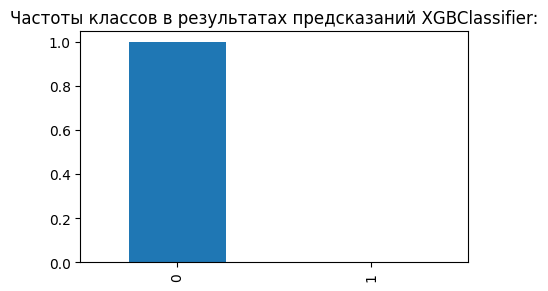

Оценка качества ROC-кривой модели XGBClassifier:

Для модели XGBClassifier параметр ROC = 0.516


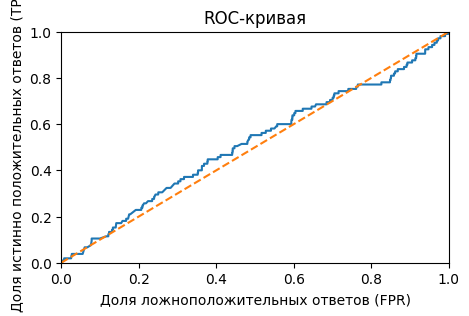

In [127]:
pres_recall_f1(target_test_ap, features_test_ap.drop(['first_date'], axis=1),\
               predictions_ap, best_model_ap, 'XGBClassifier')
#pres_recall_f1(target_test_ap, features_test_scale_ap, predictions_ap, best_model_ap, 'DT')

- **Точность Precision = 0.012 и Полнота Recall = 0.676**, данные близки к константной модели
- наблюдается доминирование ложно-положительных ответов, при этом точность очень низкая.
- ROC-кривая практически совпадает с константной.
- из всего этого делаю вывод, что модель на основе данных - переобучается.

#### **Магазин подарков**

In [108]:
%%time
pipeline = Pipeline([('сlassifiсation', model_1)])
params = [ param2, param3, param4, param5] #,param1

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21 µs


In [109]:
%%time
start = time.time()
rs_g = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1')\
                          .fit(features_upsampled_g.drop(['first_date'], axis=1), target_upsampled_g) #.drop(['first_date'], axis=1)
end = time.time()
t_rs_g=round(end-start,2)

CPU times: user 426 ms, sys: 48.3 ms, total: 474 ms
Wall time: 20.9 s


In [119]:
# Получение наилучших параметров и модели
best_params_g = rs_g.best_params_
best_model_g = rs_g.best_estimator_
print(rs_g.best_params_)
print()
# F1-мера для лучшей модели
f1_rs_g = rs_g.best_score_
print(f'F1-мера лучшей модели, найденная методом RandomSCV F1_train = {round(f1_rs_g.mean(), 2)}')
print()
# Получение предсказаний модели на тестовом наборе данных
predictions_g = best_model_g.predict(features_test_g.drop(['first_date'], axis=1))

# Вычисление и вывод метрик precision, recall, F1-score
report_g = classification_report(target_test_g, predictions_g)
print(report_g)

{'сlassifiсation': LGBMClassifier(class_weight='balanced', max_depth=3, n_estimators=300,
               num_leaves=40, random_state=12345, verbose=-1), 'сlassifiсation__boosting_type': 'gbdt', 'сlassifiсation__learning_rate': 0.1, 'сlassifiсation__max_depth': 3, 'сlassifiсation__n_estimators': 300, 'сlassifiсation__num_leaves': 40}

F1-мера лучшей модели, найденная методом RandomSCV F1_train = 0.95

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        74
           1       0.00      0.00      0.00         3

    accuracy                           0.95        77
   macro avg       0.48      0.49      0.49        77
weighted avg       0.92      0.95      0.94        77



Оценка качества модели LGBMClassifier:

Доля правильных ответов Accuracy = 0.948
Точность Precision = 0.000
Полнота Recall = 0.000
Гармоническое среднее F-мера = 0.000
AUR_ROC = 0.6846846846846847
Матрица ошибок  LGBMClassifier
[[73  1]
 [ 3  0]]
Частоты классов в результатах предсказаний LGBMClassifier:
0   0.987
1   0.013
dtype: float64
Axes(0.125,0.11;0.775x0.77)


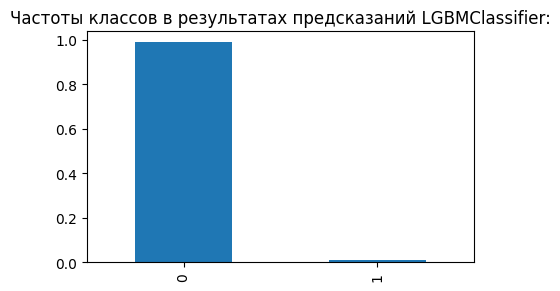

Оценка качества ROC-кривой модели LGBMClassifier:

Для модели LGBMClassifier параметр ROC = 0.685


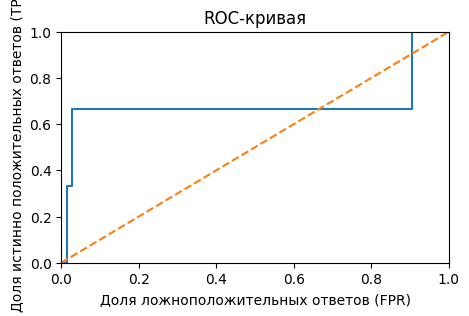

In [120]:
pres_recall_f1(target_test_g, features_test_g.drop(['first_date'], axis=1),\
               predictions_g, best_model_g, 'LGBMClassifier')

- Безумные результаты - просто нулевая `**Точность Precision = 0.000**` и `**Полнота Recall = 0.000**`. Очень маленький набор данных - надо будет попробовать другой подход
- наблюдается доминирование истинно-положительных ответов, при этом точности нет.
- ROC-кривая вообще ведет себя странно - очень далеко от классики.
- из всего этого делаю вывод, что модель на основе данных - явно переобучается.

#### **Макетплейсы**

In [112]:
%%time
pipeline = Pipeline([('сlassifiсation', model_1)])
params = [ param1, param2, param4, param5] #, param3

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21.2 µs


In [114]:
%%time
start = time.time()
rs_m = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='f1')\
                          .fit(features_upsampled_m.drop(['first_date'], axis=1), target_upsampled_m) #.drop(['first_date'], axis=1)
end = time.time()
t_rs_m=round(end-start,2)

CPU times: user 16.7 s, sys: 458 ms, total: 17.2 s
Wall time: 2min 50s


In [118]:
# Получение наилучших параметров и модели
best_params_m = rs_m.best_params_
best_model_m = rs_m.best_estimator_
print(rs_m.best_params_)
print()
# F1-мера для лучшей модели
f1_rs_m = rs_m.best_score_
print(f'F1-мера лучшей модели, найденная методом RandomSCV F1_train = {round(f1_rs_m.mean(), 2)}')
print()
# Получение предсказаний модели на тестовом наборе данных
predictions_m = best_model_m.predict(features_test_m.drop(['first_date'], axis=1))

# Вычисление и вывод метрик precision, recall, F1-score
report_m = classification_report(target_test_m, predictions_m)
print(report_g)

{'сlassifiсation': RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=609, random_state=12345), 'сlassifiсation__bootstrap': True, 'сlassifiсation__max_depth': None, 'сlassifiсation__max_features': 'log2', 'сlassifiсation__n_estimators': 609}

F1-мера лучшей модели, найденная методом RandomSCV F1_train = 0.9

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        74
           1       0.00      0.00      0.00         3

    accuracy                           0.95        77
   macro avg       0.48      0.49      0.49        77
weighted avg       0.92      0.95      0.94        77



Оценка качества модели RandomForestClassifier:

Доля правильных ответов Accuracy = 0.873
Точность Precision = 0.063
Полнота Recall = 0.096
Гармоническое среднее F-мера = 0.076
AUR_ROC = 0.5657355558292223
Матрица ошибок  RandomForestClassifier
[[3471  311]
 [ 198   21]]
Частоты классов в результатах предсказаний RandomForestClassifier:
0   0.917
1   0.083
dtype: float64
Axes(0.125,0.11;0.775x0.77)


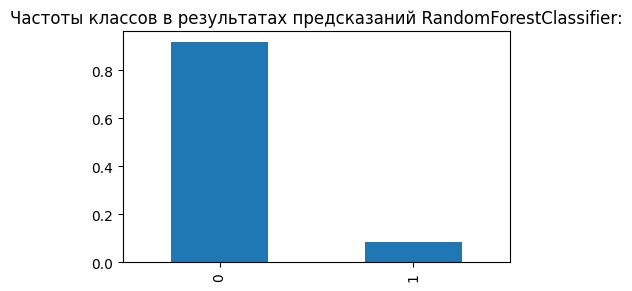

Оценка качества ROC-кривой модели RandomForestClassifier:

Для модели RandomForestClassifier параметр ROC = 0.566


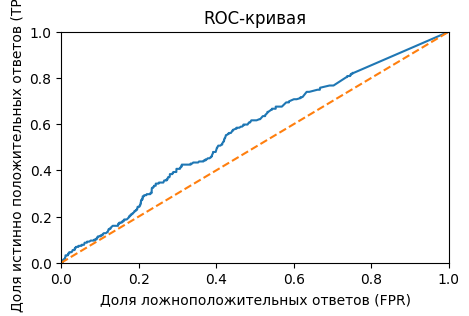

In [122]:
pres_recall_f1(target_test_m, features_test_m.drop(['first_date'], axis=1),\
               predictions_m, best_model_m, 'RandomForestClassifier')

- **Точность Precision = 0.063 и Полнота Recall = 0.096**, данные близки к константной модели
- наблюдается доминирование истинно-положительных ответов, при этом точность также очень низкая.
- ROC-кривая чуть лучше константной.
- из всего этого делаю вывод, что модель на основе данных - переобучается.

## **Выводы:**
- Анализ данных показал, что во всех магазинах мало повторных юзеров - таргет маленький совсем, лучще всего ситуация с данными макетплейса: 5% таргета.
- Сезонность присутствует во всех магазинах, причем сезонность разная.
 > интересное наблюдение, что на маркет плейсе количество сделок не совпадает с общим уровнем дохода - видимо, в сезоны распродаж наиболее дорогие товары покупают.
- в данных много продаж от одного покупателя в одно время - при формировании итогового датасета для обучения модели считала за 1 продажу.
- выбрала в качестве подхода - стационарную модель.
 - создала следующие фичи:
   - 1 и последнюю дату покупки (при обучении модели не испльзовала)
   - количество покупок
   - период времени между 1 и 2 покупкой
   - средний чек - затем удалила для модели из-за.
   - минимальный чек
   - максимальный чек
 - Обрезала датасет на 1 месяц, на основе этого последнего месяца создали добавили таргет.
 - При формировании целевого признака обнаружила большой дисбаланс калассов - применила увеличение и уменьшение целевого признака, также сделаа баллансировку данных.
- для обучения модели взяла изначально 6 моделей:
  - Модель LogisticRegression
  - Дерева решений
  - Модель Случайного леса
  - Модель CatBoost
  - Модель LGBMRegressor
  - Модель XGBRegressor (по возможности)
- Предварительно проела обработку данных следующими методами:
    - сбалансированных чистых данных
    - стандартизированных данных
    - увеличенной выборке положительного класса
    - уменьшенной выборке 0 класса

- Провела кроссвалидацию на разных данных: в итоге выявила, что лучшие результаты показали модели на сбаллансированной увеличенной выборке положительного класса. На ней и проводила обучение.
  > но так как выборки малы, то синтетические данные на обучающей выдорке могут привести к тому, что на тесте будут результаты значительно хуже. Что в последствии и произошло.
- Для данных разных магазинов выбрала по 4 модели с лучшими показателями на кроссвалидации:
   - Для магазина одежды:
     - **XGBClassifier**
     - RandomForestClassifier (RF)
     - DecisionTreeClassifier (DT)
     - CatBoostClassifier
   - Для магазина подарков:
     - **RandomForestClassifier (RF)**
     - CatBoostClassifier
     - XGBClassifier
     - LGBMClassifier
   - Для макетплейса:
     - **RandomForestClassifier (RF)**
     - DecisionTreeClassifier (DT)
     - XGBClassifier
     - LGBMClassifier
- Обучение моделей и подбор гиперпараметров проводила методом `RandomizedSearchCV`
- в итоге **на тестовой выборке** данные (сбаллансированныне и upsample) показали, что все модели переобучаются. Поэтому надо попробовать другой подход:
  - **Магазин одежды:**
    - Лучшая модель:
     > **XGBClassifier**('learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300)
    - Доля правильных ответов Accuracy = 0.163
    - Точность Precision = 0.012
    - Полнота Recall = 0.676
    - Гармоническое среднее F-мера = 0.023
    - AUR_ROC = 0.5160
  - **Магазин подарков:**
    - Лучшая модель:
     > **LGBMClassifier**(max_depth=3, n_estimators=300,
      num_leaves=40, boosting_type: 'gbdt', learning_rate: 0.1)
    - Доля правильных ответов Accuracy = 0.948
    - Точность Precision = 0.0
    - Полнота Recall = 0.0
    - Гармоническое среднее F-мера = 0.0
    - AUR_ROC = 0.68
  - **Макеплейсы:**
    - Лучшая модель:
     > **RandomForestClassifier**(max_features='log2', n_estimators=609, 'bootstrap': True, 'max_depth': None)

    - Доля правильных ответов Accuracy = 0.873
    - Точность Precision = 0.063
    - Полнота Recall = 0.096
    - Гармоническое среднее F-мера = 0.076
    - AUR_ROC = 0.566

- **Точность Precision** и **Полнота Recall** на всех выборках очень низкие, данные близки к константной модели. Лучше показатели на данных макетплейса (но они как раз более обширные).
- наблюдается доминирование истинно-положительных ответов, при этом точность очень низкая.
- ROC-кривая чуть лучше константной или странно себя ведет.
- из всего этого делаю вывод, что модель на основе данных - переобучается.
- основной причиной переобучения вижу очень маленький набор данных.
  > особенно это видно на данных магазина подарков - 200 строчек - это очень мало, особеннно когда данные несбаллансированы и тербуюся приемы баллансировки.

**Как можно улучшить результат:**
  - попробоввать динамический подход - предсказвать вероятность продажи каждые 30 дней.
  - также можно попробовать подход именно на основе временного ряда (задачу регрессии).